# Logistic Function and Bayesian Inference

Sebastien Soudan

In [1]:
import os

import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import arviz as az

import matplotlib.pylab as plt

from IPython.core.display_functions import display

In [2]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

assert numpyro.__version__.startswith("0.9.1")

numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

/opt/homebrew/Caskroom/miniforge/base/envs/bayesian_inference_tut/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Synthetic data

Let's make our own data following a noisy logistic function.

In [3]:
def logistic(L, k, x_0, noise_scale=0, x_min=0, x_max=1, n_points=100):
    x = np.linspace(x_min, x_max, n_points)
    noise = np.random.normal(0, noise_scale, size=n_points)
    return x, L / (1 + np.exp(-k * (x - x_0))) + noise

In [4]:
L = 4
k = 1.2
x_0 = 5.
n_points = 100

x_min=0
x_max=10

noise_scale = 0.01

x         y
0  0.00000  0.017940
1  0.10101 -0.002008
2  0.20202  0.009424
3  0.30303  0.006678
4  0.40404  0.010657

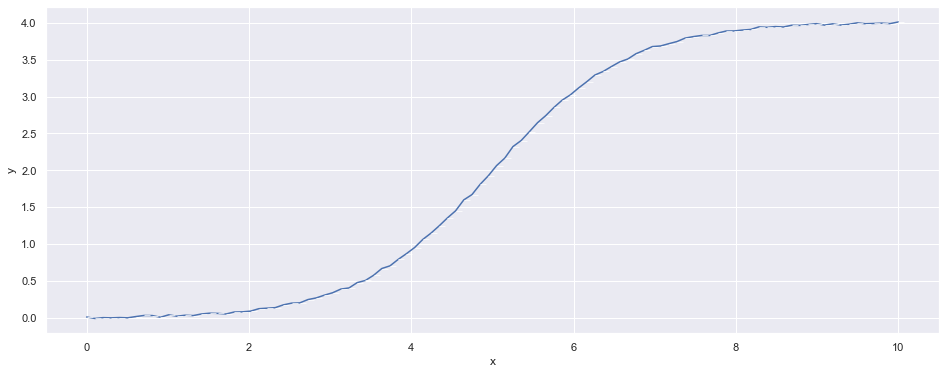

In [5]:
df = pd.DataFrame(np.transpose(logistic(L=L, k=k, x_0=x_0, noise_scale=noise_scale, x_min=x_min, x_max=x_max, n_points=n_points)), columns=['x', 'y'])
display(df.head())

plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='x', y='y', marker=True)
plt.show()
plt.close()

## Definition of the model

In [6]:
def model(t_obs, y_obs=None):
    t_max = jnp.max(t_obs)
    y_max = jnp.max(y_obs)

    L = numpyro.sample("L", dist.TruncatedNormal(y_max, y_max/2, low=y_max))
    t_0 = numpyro.sample("t_0", dist.Normal(t_max, t_max/2))
    k = numpyro.sample("k", dist.TruncatedNormal(1.0, 3.0, low=0)) # TODO(ssoudan) estimate with the steepest slope observed?

    y_est = L / (1 + jnp.exp(-k*(t_obs-t_0)))

    eps = numpyro.sample("epsilon", dist.HalfNormal())

    numpyro.sample("y", dist.Normal(y_est, eps), obs=y_obs)


## Inference on truncated data

We limit our 'observation data' to the beginning of the syntethic data we generated to see how it behaves.

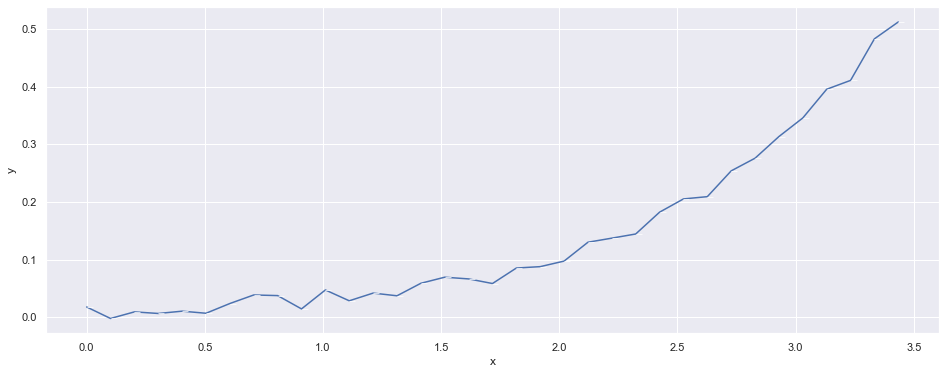

In [7]:
df_obs = df[:int(n_points*0.35)]

plt.figure(figsize=(16,6))
sns.lineplot(data=df_obs, x='x', y='y', marker=True)
plt.show()
plt.close()

In [8]:
t_obs =  df_obs['x'].values
y_obs = df_obs['y'].to_numpy()

The graphical representation of our model:

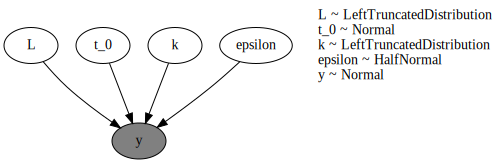

In [9]:
numpyro.render_model(model, model_args=(t_obs, y_obs), render_distributions=True)

Sample!

In [10]:
def predict(t_obs, y_obs):
    nuts_kernel = NUTS(model)

    mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, num_chains=3)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, t_obs=t_obs, y_obs=y_obs)

    mcmc.print_summary()

    posterior_samples = mcmc.get_samples()

    prior = Predictive(model, num_samples=500)(
        random.PRNGKey(2), t_obs, y_obs
    )
    return mcmc, prior, posterior_samples

For reference, here are values we used:

In [11]:
print(f"L={L}")
print(f"k={k}")
print(f"x_0={x_0}")

L=4
k=1.2
x_0=5.0


In [12]:
mcmc, prior, posterior_samples = predict(t_obs, y_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      1.20      0.14      1.19      0.97      1.43   1029.34      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   1736.58      1.00
         k      1.43      0.06      1.43      1.34      1.53   1132.11      1.00
       t_0      3.65      0.14      3.65      3.42      3.88   1005.59      1.00

Number of divergences: 0


The table right above gives some statistics on the distributions of the different parameters.

Little bit of diagnostic of the run of the sampling below. The assumption behind MCMC is that we sample from a Markov chain that has reached its stationary distribution. We want the charts on the right to look like 'hairy caterpillars' as said in the litterature.

Charts on the left are (empirical) posterior distributions of our parameters.

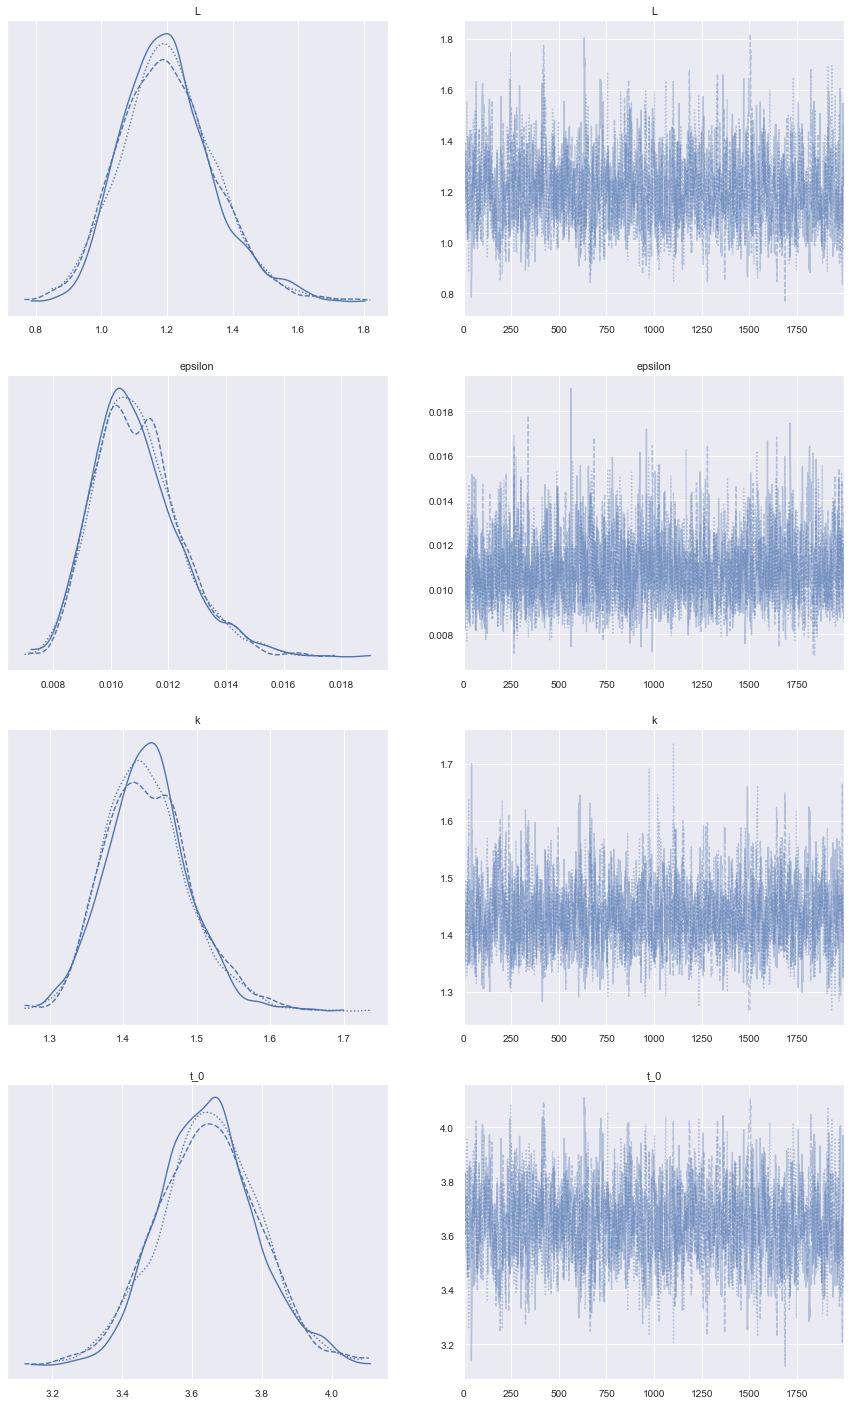

In [13]:
posterior_predictive = Predictive(model, posterior_samples)(
    random.PRNGKey(1), t_obs, y_obs
)

data = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data, compact=True, figsize=(15, 25));

We might want to look at them jointly to understand the relationship between the different parameters that match our data.

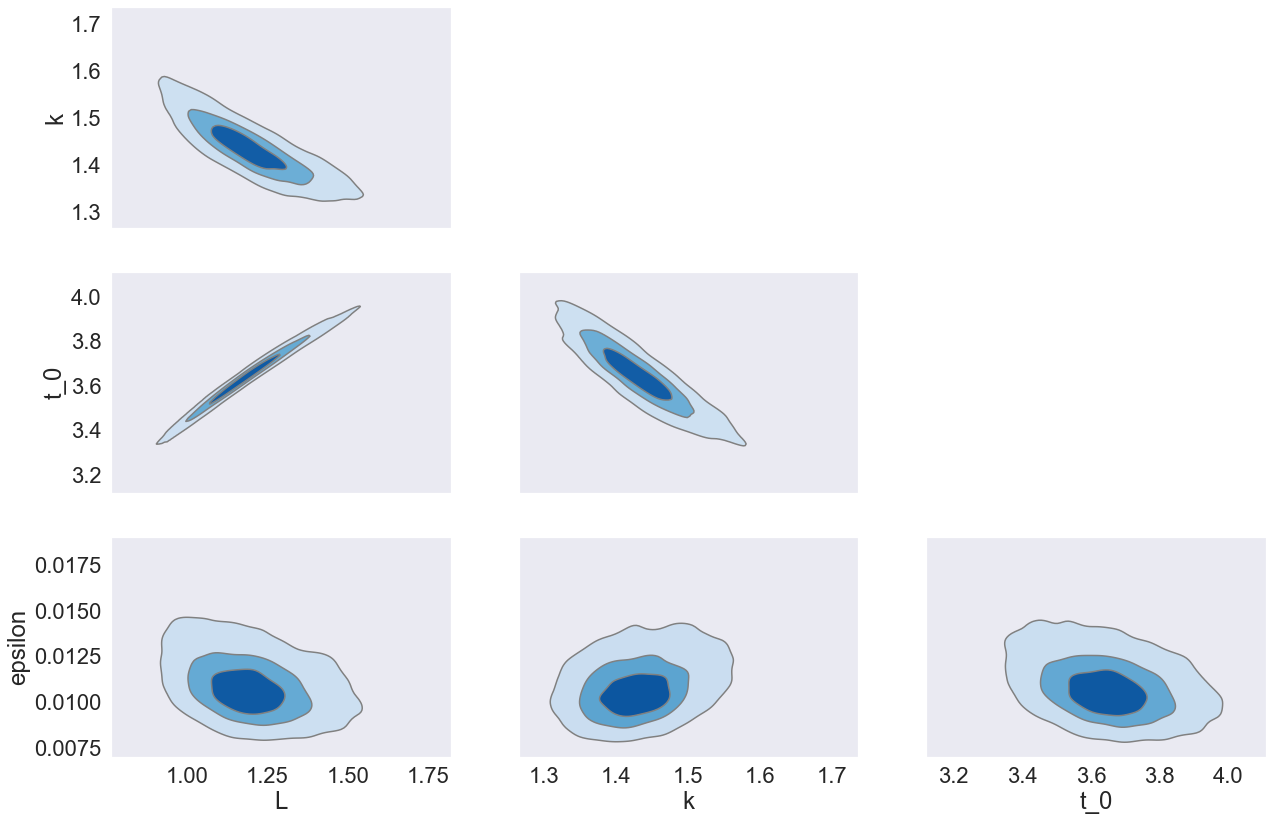

In [14]:
az.plot_pair(
    data,
    var_names=["L", "k", "t_0", "epsilon"],
    kind="kde",
    divergences=True,
    textsize=22,
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
)
plt.show()
plt.close()

Let's reconstruct the logistic function from these parameters and compare them with the data.

In [15]:
def build_predictive_posteriors(x_min, x_max, n_points, posterior_samples):
    x_pred = np.linspace(x_min, x_max, n_points)

    n_samples = len(posterior_samples['L'])

    y_pred = np.zeros((n_points, n_samples,))
    for i in range(n_samples):
        L_ = posterior_samples["L"][i]
        k_ = posterior_samples["k"][i]
        t_0_ = posterior_samples["t_0"][i]

        y_pred[:, i] = L_ / (1 + np.exp(-k_*(x_pred-t_0_)))

    return x_pred, y_pred

In [16]:
x_pred, y_pred = build_predictive_posteriors(x_min=x_min, x_max=x_max, n_points=n_points, posterior_samples=posterior_samples)
print(y_pred.shape)

(100, 6000)


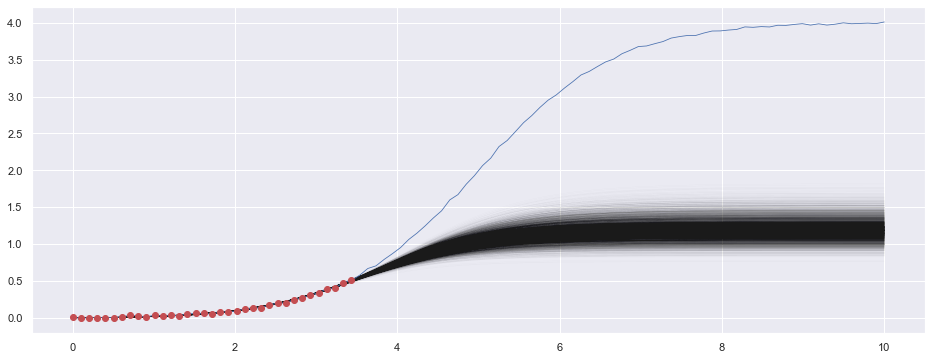

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(x_pred, y_pred, linewidth=0.2, color='k', alpha=0.03, zorder=1)
plt.plot(df['x'], df['y'], color='b', zorder=2, linewidth=0.8)
plt.scatter(t_obs, y_obs, zorder=3, color='r')
plt.show()
plt.close()

# Interactive

Interactive version so the influence of some parameters can be tested.

In [18]:
L = 4
k = 1.2
x_0 = 5.
n_points = 100

x_min = 0
x_max = 10

In [19]:
%matplotlib widget

from ipywidgets import interactive
import ipywidgets as widgets

def f(a, b):

    df = pd.DataFrame(
        np.transpose(logistic(L=L, k=k, x_0=x_0, noise_scale=b, x_min=x_min, x_max=x_max, n_points=n_points)),
        columns=['x', 'y'])

    jj = int(a)
    df_obs = df[:jj]

    t_obs =  df_obs['x'].values
    y_obs = df_obs['y'].to_numpy()

    mcmc, prior, posterior_samples = predict(t_obs, y_obs)

    x_pred, y_pred = build_predictive_posteriors(x_min=x_min, x_max=x_max, n_points=n_points, posterior_samples=posterior_samples)

    plt.figure(figsize=(16, 6))
    plt.plot(x_pred, y_pred, linewidth=0.1, color='k', alpha=0.02, zorder=1)
    plt.plot(df['x'], df['y'], color='b', zorder=2, linewidth=0.8)
    plt.scatter(t_obs, y_obs, zorder=3, color='r')
    plt.title(f'with n={jj} points')
    plt.xlim(x_min, x_max)
    plt.ylim(-0.1*L, 1.2*L)
    plt.savefig(f'img/noise_{noise_scale}/pred_{jj:04}.png', transparent=True, dpi=200)
    plt.show()
    plt.close()

    return "aaaa"

w = interactive(f, {'manual': True},
                a=widgets.IntSlider(value=30, description='number of points', max=n_points, min=1),
                b=widgets.FloatLogSlider(value=0.01, description='noise scale', max=1, min=-4, step=0.01))

display(w)

interactive(children=(IntSlider(value=30, description='number of points', min=1), FloatLogSlider(value=0.01, d…

# Exploration of the influence of the number of points and the level of noise on the 'prediction'

x         y
0  0.00000  0.013535
1  0.10101  0.005117
2  0.20202  0.002187
3  0.30303  0.001875
4  0.40404  0.010716

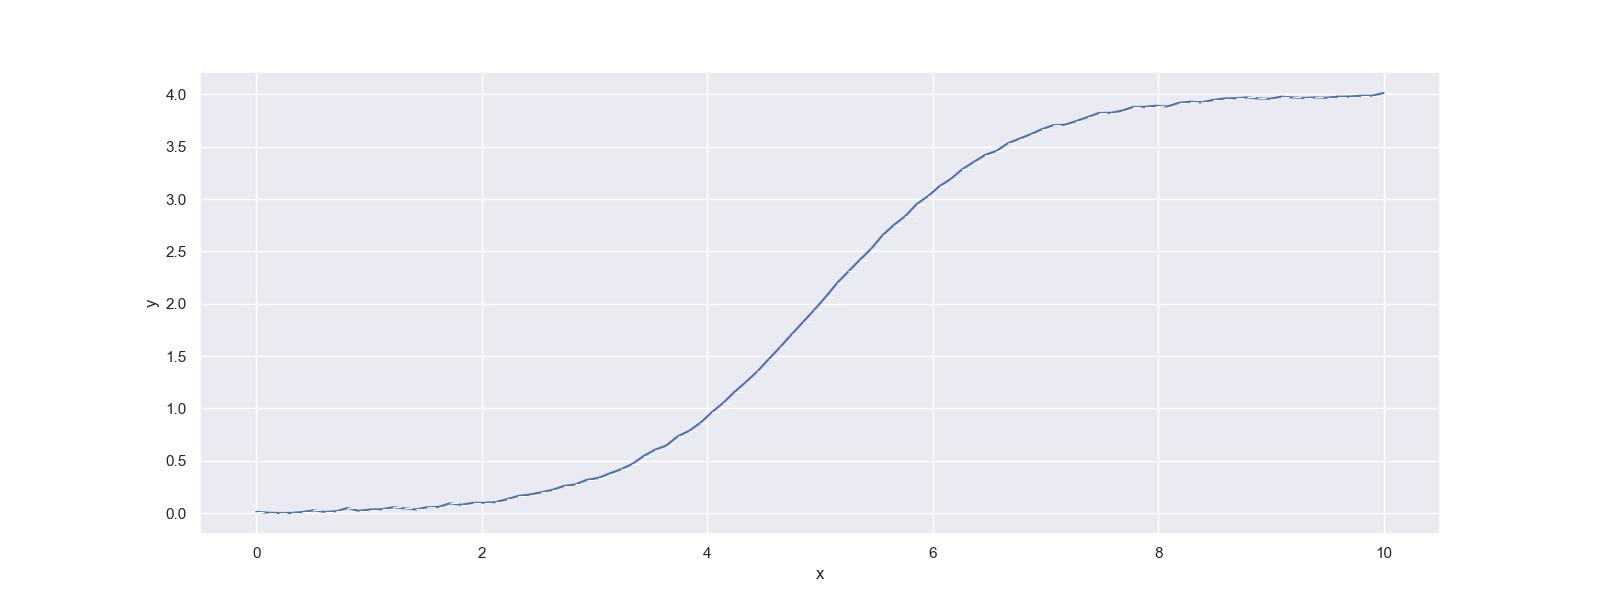

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.07      0.01      0.06      0.05      0.09   2976.29      1.00
   epsilon      0.01      0.00      0.01      0.01      0.02   2346.30      1.00
         k      2.84      1.26      2.66      0.95      4.78   2582.05      1.00
       t_0      0.97      0.23      0.93      0.60      1.32   1979.75      1.00

Number of divergences: 0


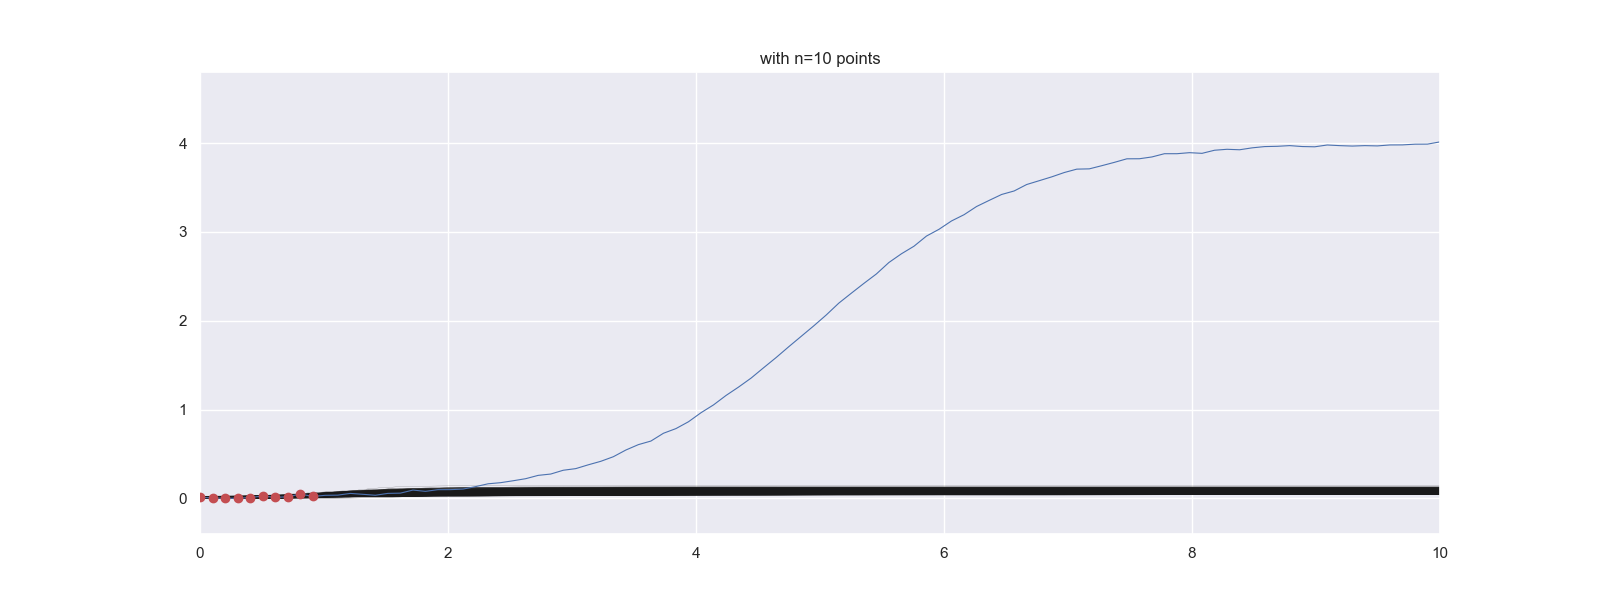

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.15      0.03      0.14      0.10      0.19   1307.98      1.00
   epsilon      0.01      0.00      0.01      0.01      0.02   1799.30      1.00
         k      1.93      0.35      1.89      1.37      2.45   1453.73      1.00
       t_0      1.65      0.23      1.64      1.28      2.00   1210.58      1.00

Number of divergences: 4


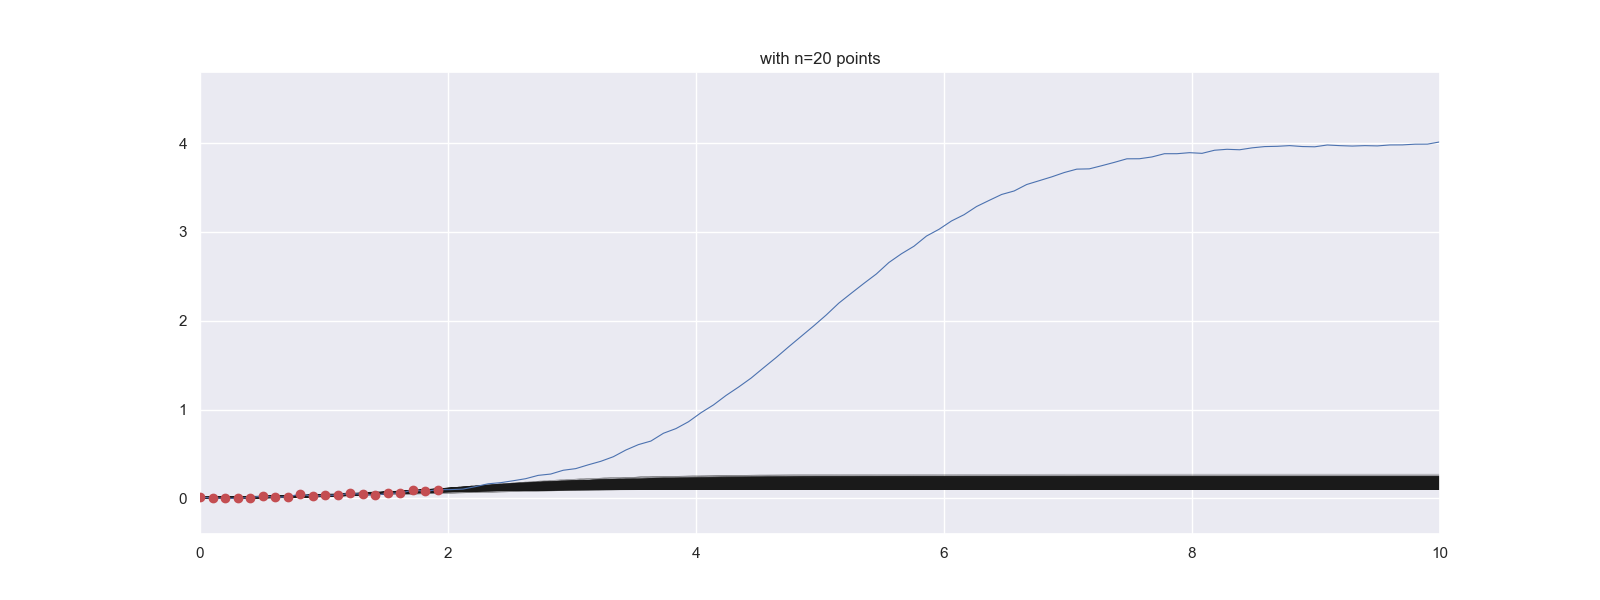

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.67      0.10      0.67      0.50      0.83    946.48      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   1614.68      1.00
         k      1.57      0.10      1.56      1.42      1.72   1056.13      1.00
       t_0      3.05      0.17      3.05      2.77      3.34    893.19      1.00

Number of divergences: 0


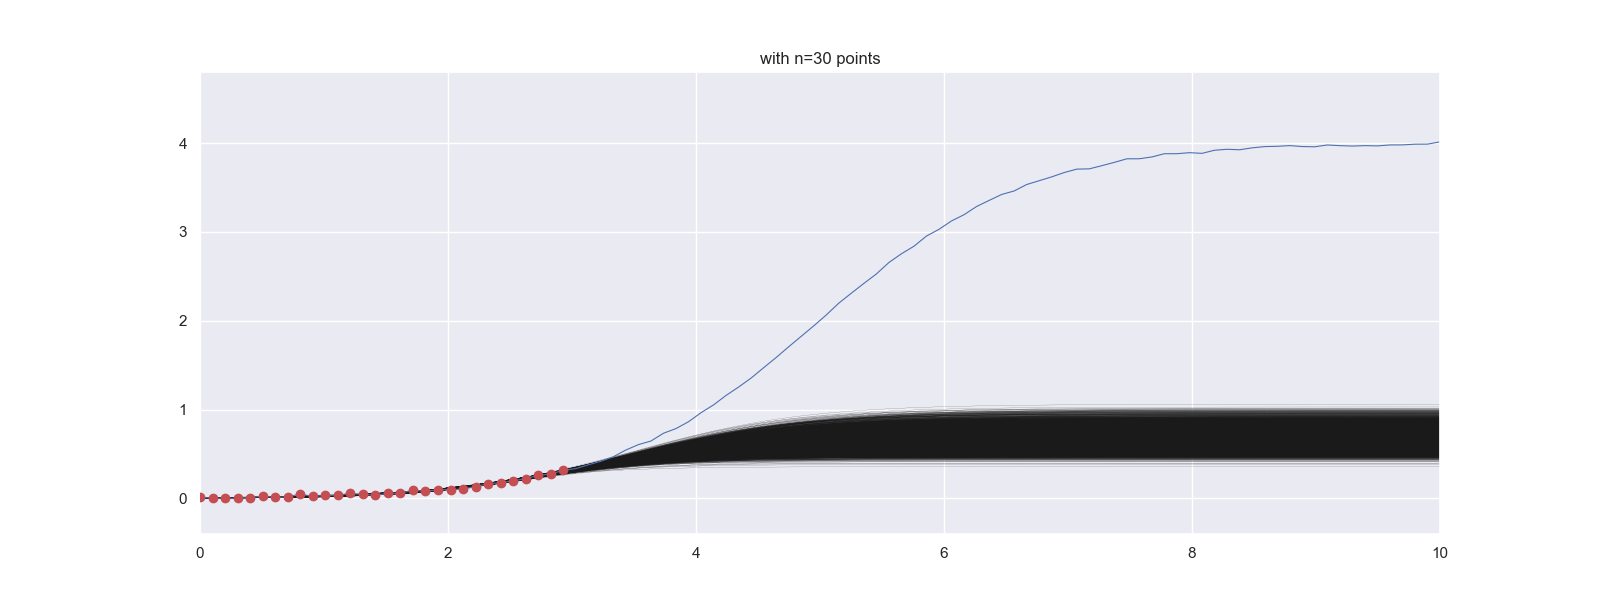

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      2.31      0.22      2.30      1.94      2.65   1105.36      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   2068.02      1.00
         k      1.32      0.03      1.31      1.26      1.37   1161.52      1.00
       t_0      4.33      0.12      4.33      4.15      4.54   1092.61      1.00

Number of divergences: 0


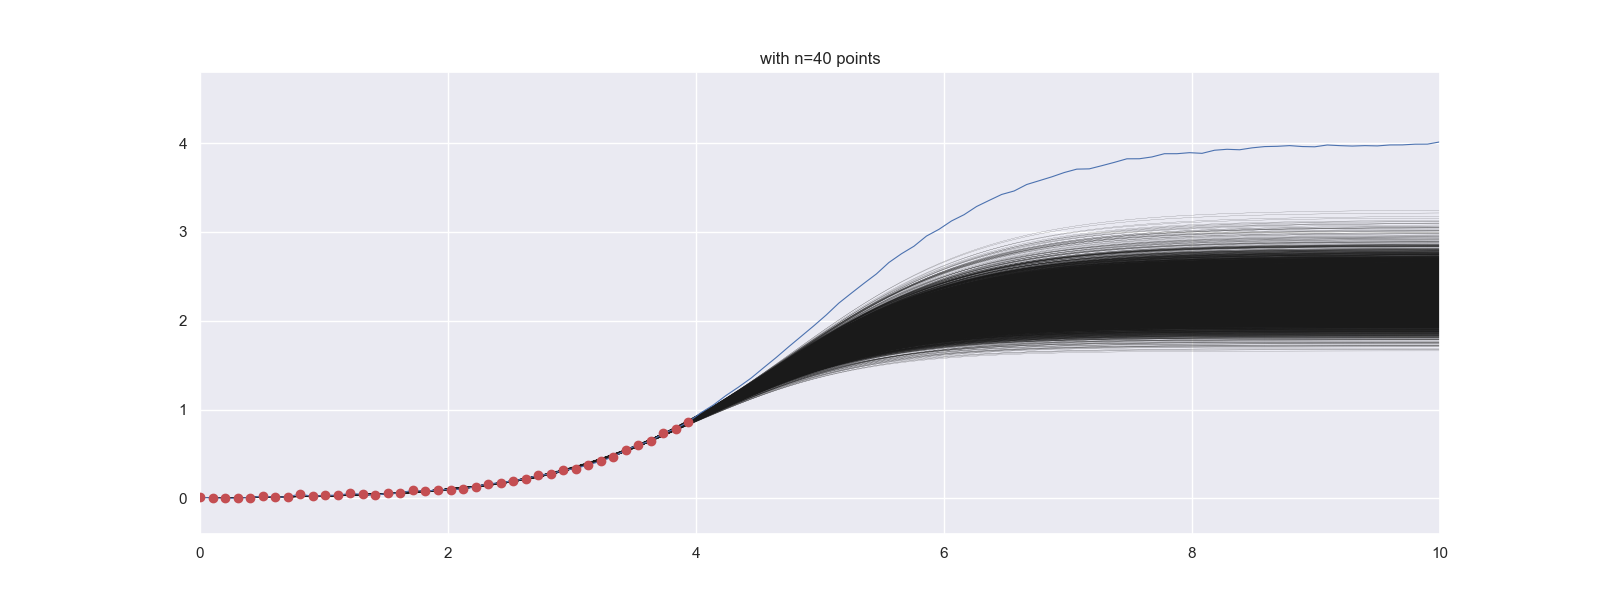

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      3.99      0.12      3.99      3.80      4.18   1178.72      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   2375.36      1.00
         k      1.20      0.01      1.20      1.18      1.22   1200.65      1.00
       t_0      4.99      0.04      4.99      4.92      5.06   1163.93      1.00

Number of divergences: 0


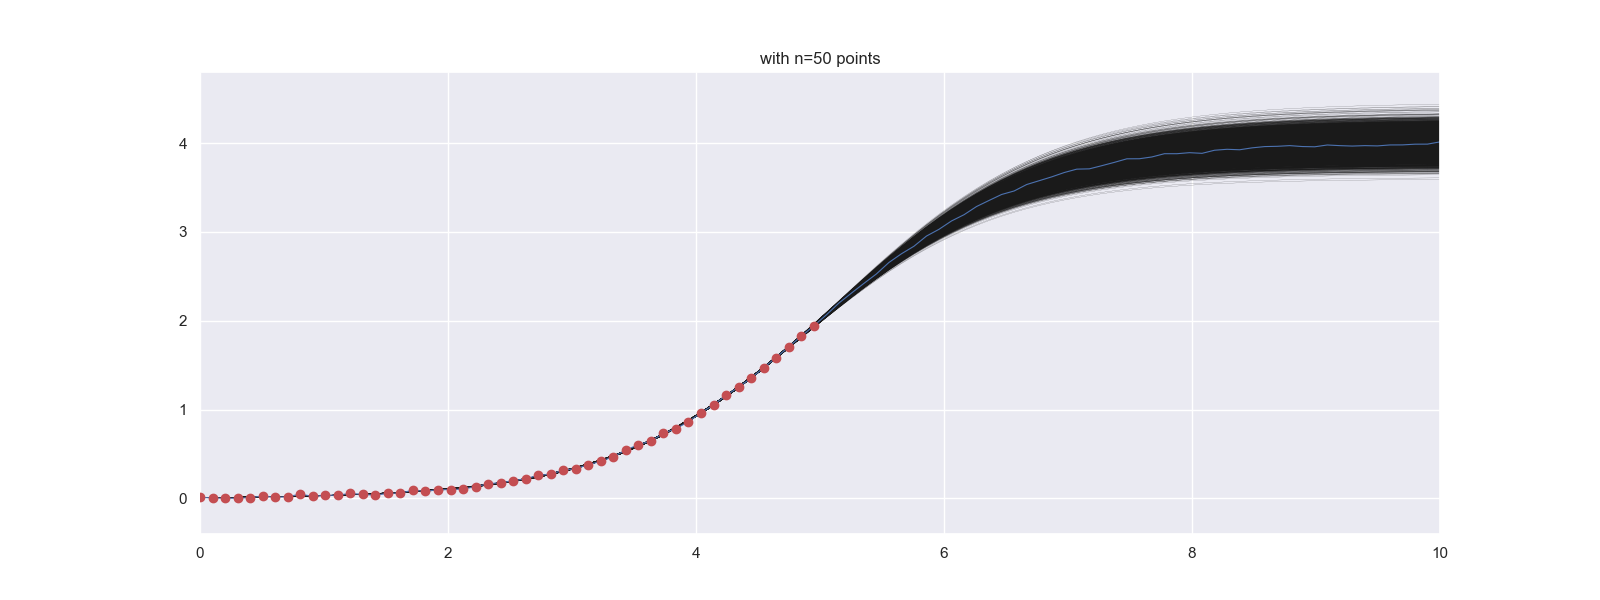

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      3.97      0.02      3.97      3.93      4.01   1562.71      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   1829.43      1.00
         k      1.21      0.01      1.21      1.20      1.22   1618.27      1.00
       t_0      4.98      0.01      4.98      4.96      5.00   1539.28      1.00

Number of divergences: 0


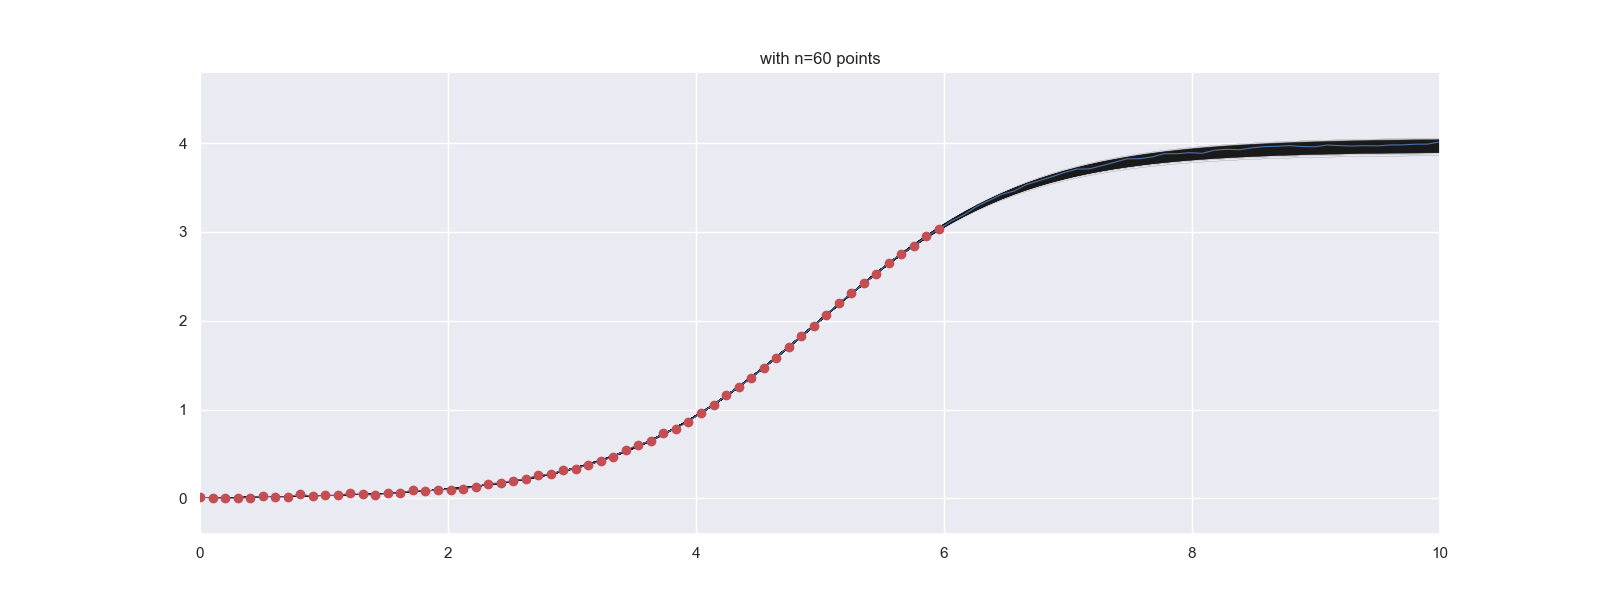

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.00      0.01      4.00      3.99      4.02   1998.02      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   2206.53      1.00
         k      1.20      0.00      1.20      1.19      1.20   2257.22      1.00
       t_0      5.00      0.00      5.00      4.99      5.01   2012.81      1.00

Number of divergences: 0


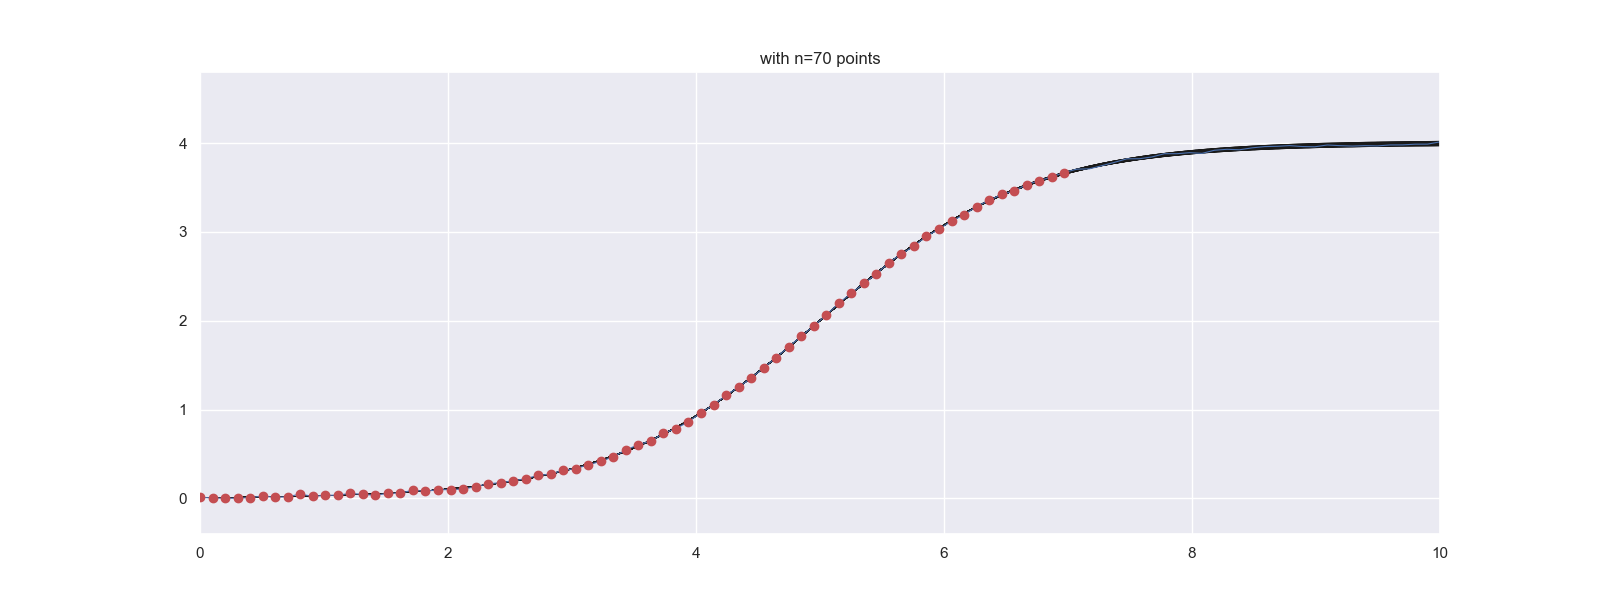

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.00      0.00      4.00      4.00      4.01   2198.82      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   2911.92      1.00
         k      1.20      0.00      1.20      1.19      1.20   2693.83      1.00
       t_0      5.00      0.00      5.00      4.99      5.00   2445.72      1.00

Number of divergences: 0


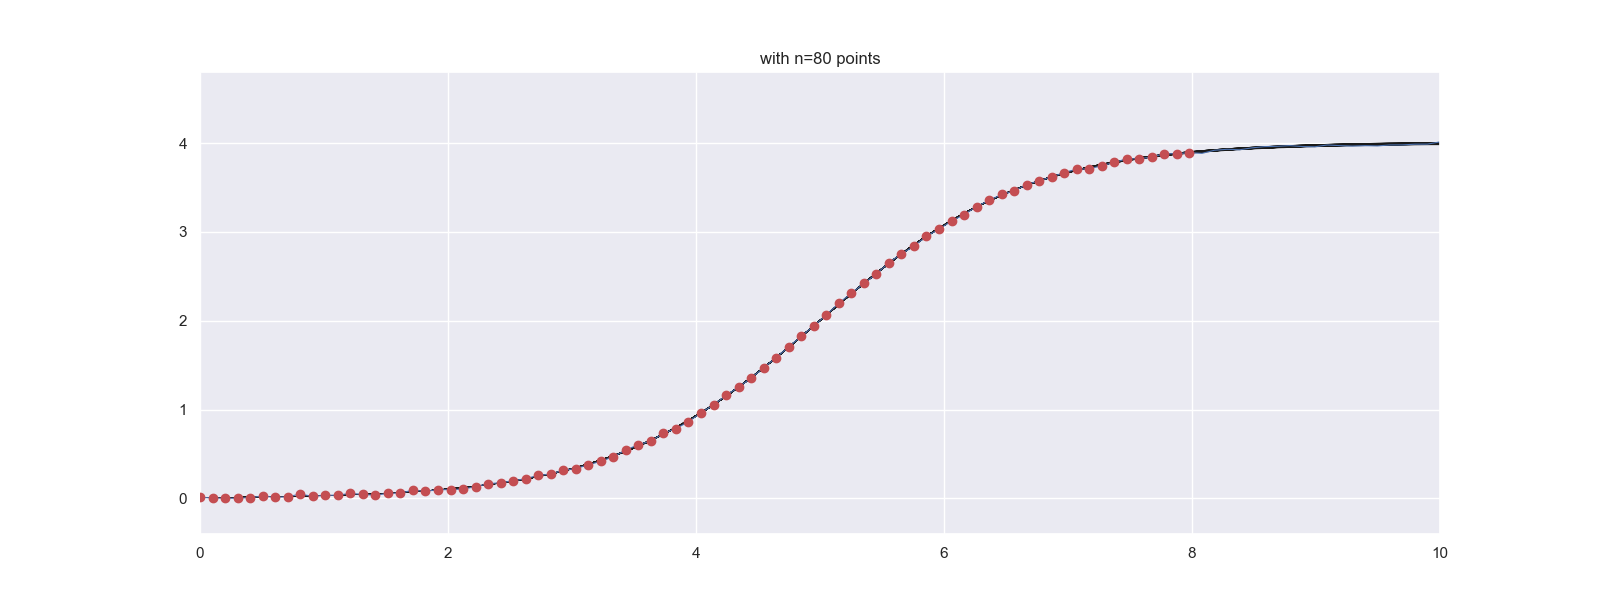

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.00      0.00      4.00      4.00      4.01   2772.30      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   3849.20      1.00
         k      1.20      0.00      1.20      1.19      1.20   3588.41      1.00
       t_0      5.00      0.00      5.00      4.99      5.00   3441.03      1.00

Number of divergences: 0


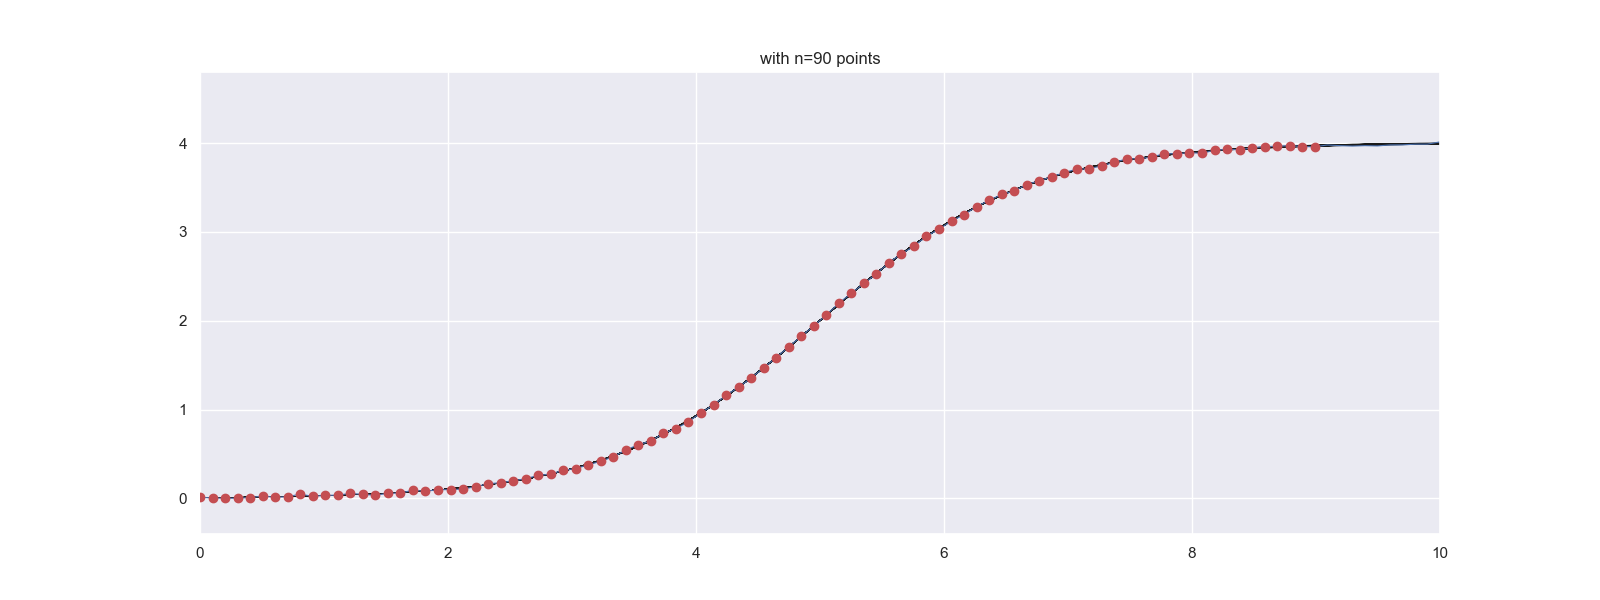

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.01      0.00      4.01      4.01      4.01   5279.78      1.00
   epsilon      0.01      0.00      0.01      0.01      0.01   4501.69      1.00
         k      1.19      0.00      1.19      1.19      1.20   6444.24      1.00
       t_0      5.01      0.00      5.01      5.00      5.01   6170.94      1.00

Number of divergences: 0


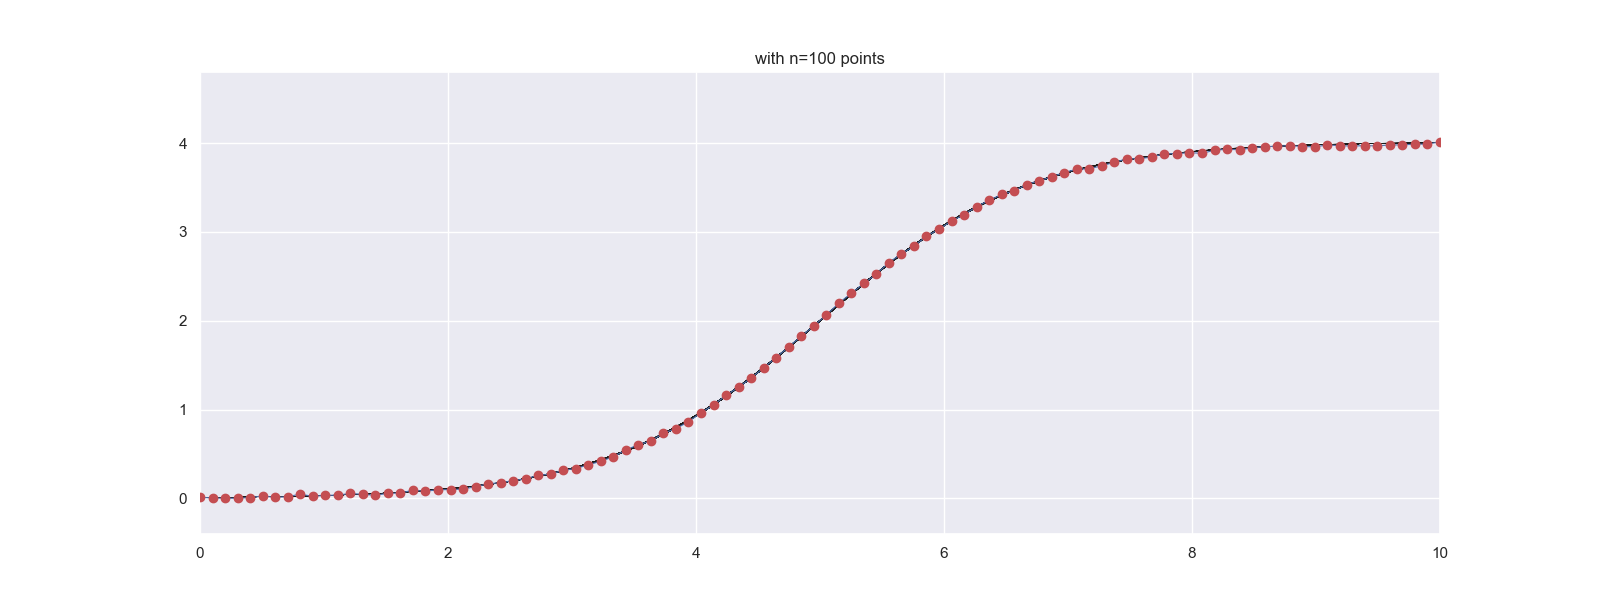

x         y
0  0.00000  0.195245
1  0.10101  0.050848
2  0.20202  0.079912
3  0.30303 -0.086962
4  0.40404  0.051835

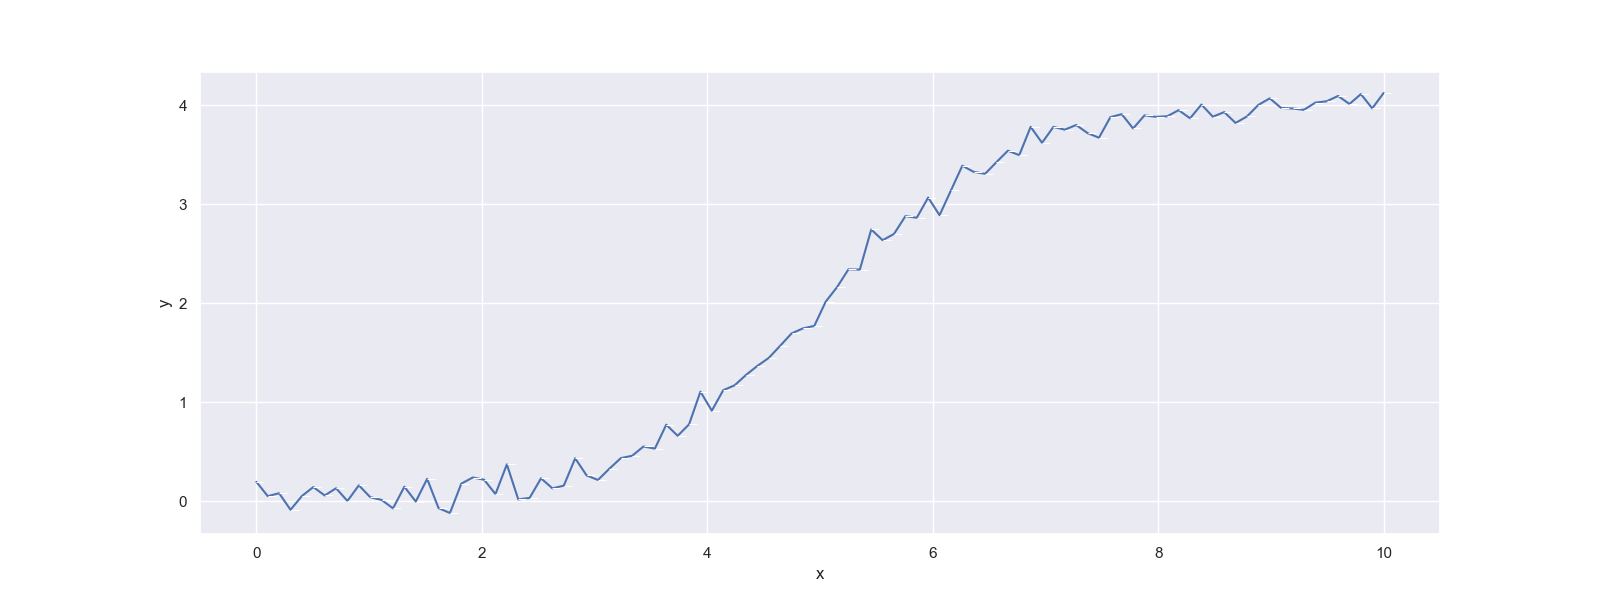

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.26      0.05      0.24      0.20      0.33   3101.86      1.00
   epsilon      0.10      0.03      0.09      0.06      0.14   2895.85      1.00
         k      2.03      1.55      1.65      0.00      4.18   4391.75      1.00
       t_0      1.01      0.36      0.99      0.43      1.60   2896.57      1.00

Number of divergences: 5


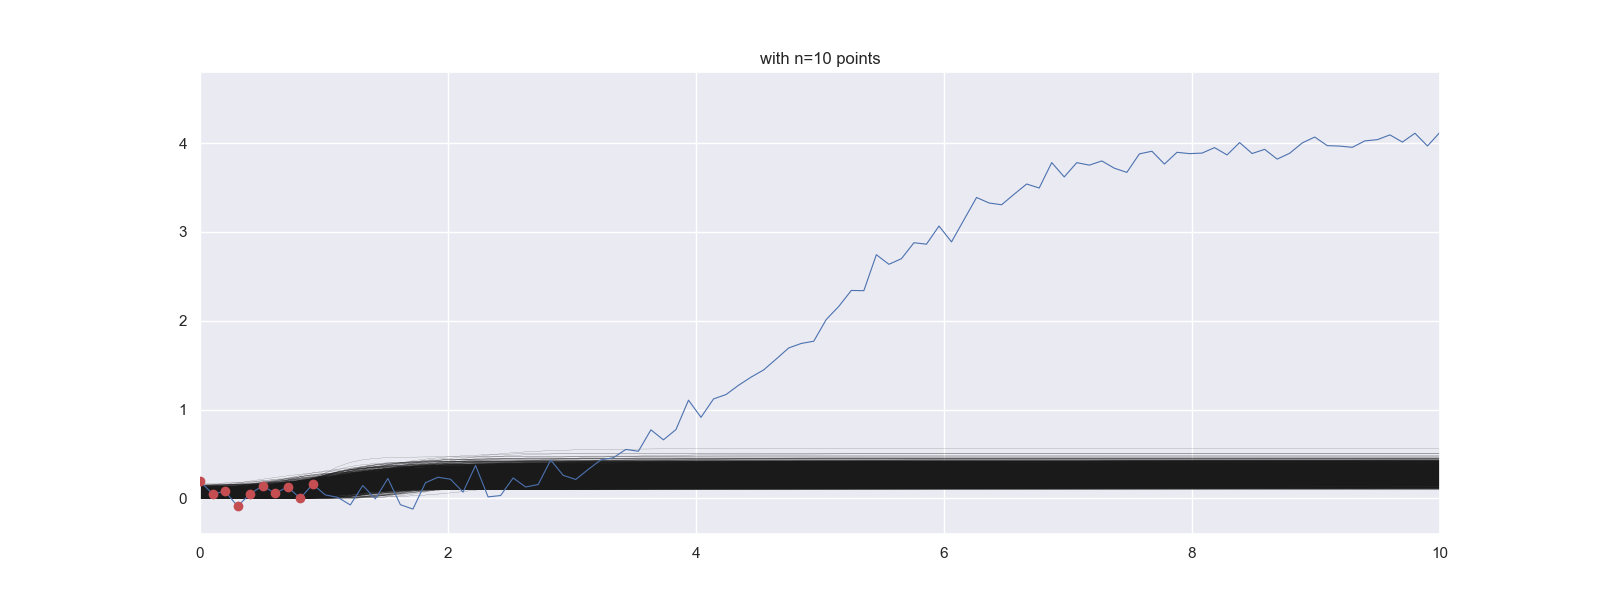

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.32      0.06      0.30      0.24      0.41   3065.80      1.00
   epsilon      0.12      0.02      0.12      0.09      0.15   3697.11      1.00
         k      2.04      1.65      1.49      0.05      4.51   2584.45      1.00
       t_0      2.39      0.61      2.28      1.56      3.47   2366.86      1.00

Number of divergences: 3


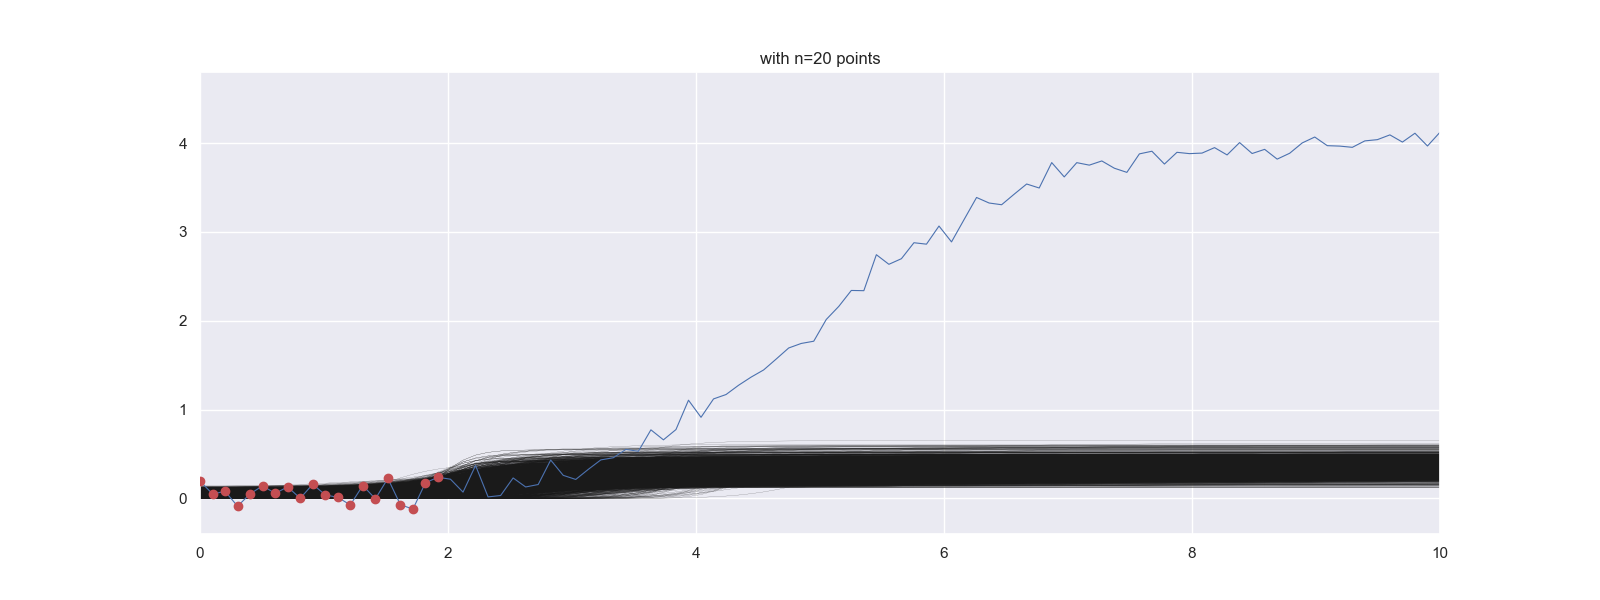

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.58      0.12      0.56      0.43      0.76   3085.71      1.00
   epsilon      0.12      0.02      0.12      0.09      0.15   3050.69      1.00
         k      1.22      0.66      1.08      0.34      2.04   2662.41      1.00
       t_0      3.31      0.61      3.18      2.42      4.24   2148.40      1.00

Number of divergences: 4


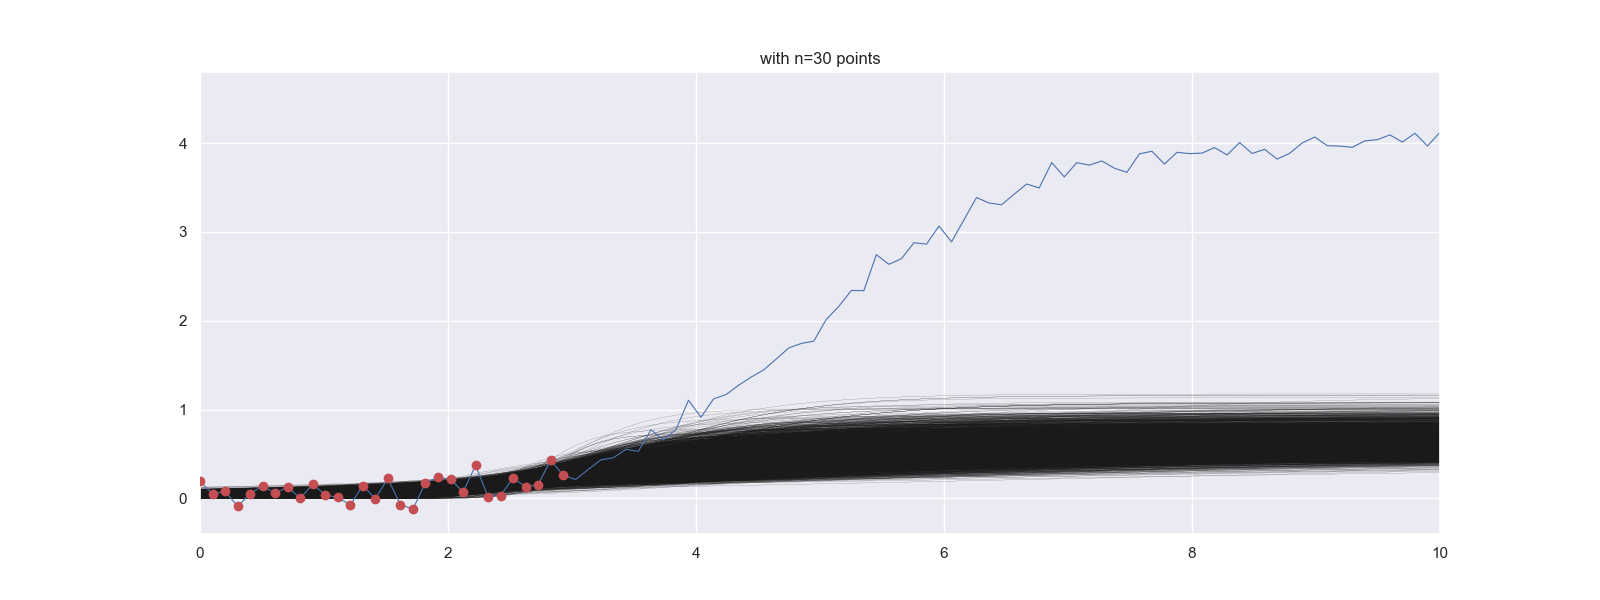

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      1.72      0.36      1.68      1.11      2.21   1936.59      1.00
   epsilon      0.12      0.01      0.12      0.10      0.14   2478.17      1.00
         k      1.66      0.28      1.63      1.22      2.12   2452.65      1.00
       t_0      3.88      0.25      3.88      3.48      4.28   1766.20      1.00

Number of divergences: 0


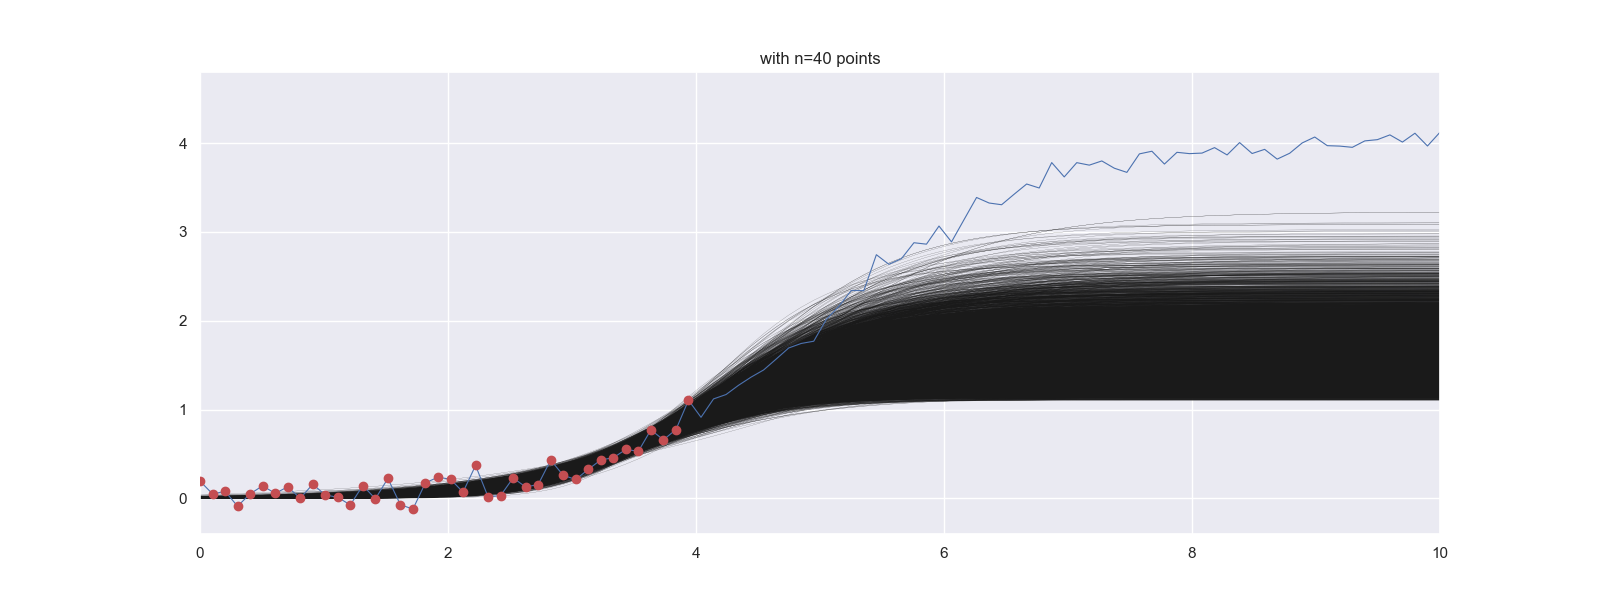

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      2.70      0.40      2.64      2.10      3.32   1352.61      1.00
   epsilon      0.11      0.01      0.10      0.09      0.12   2102.84      1.00
         k      1.42      0.15      1.41      1.19      1.67   1423.62      1.00
       t_0      4.41      0.22      4.39      4.03      4.74   1341.09      1.00

Number of divergences: 0


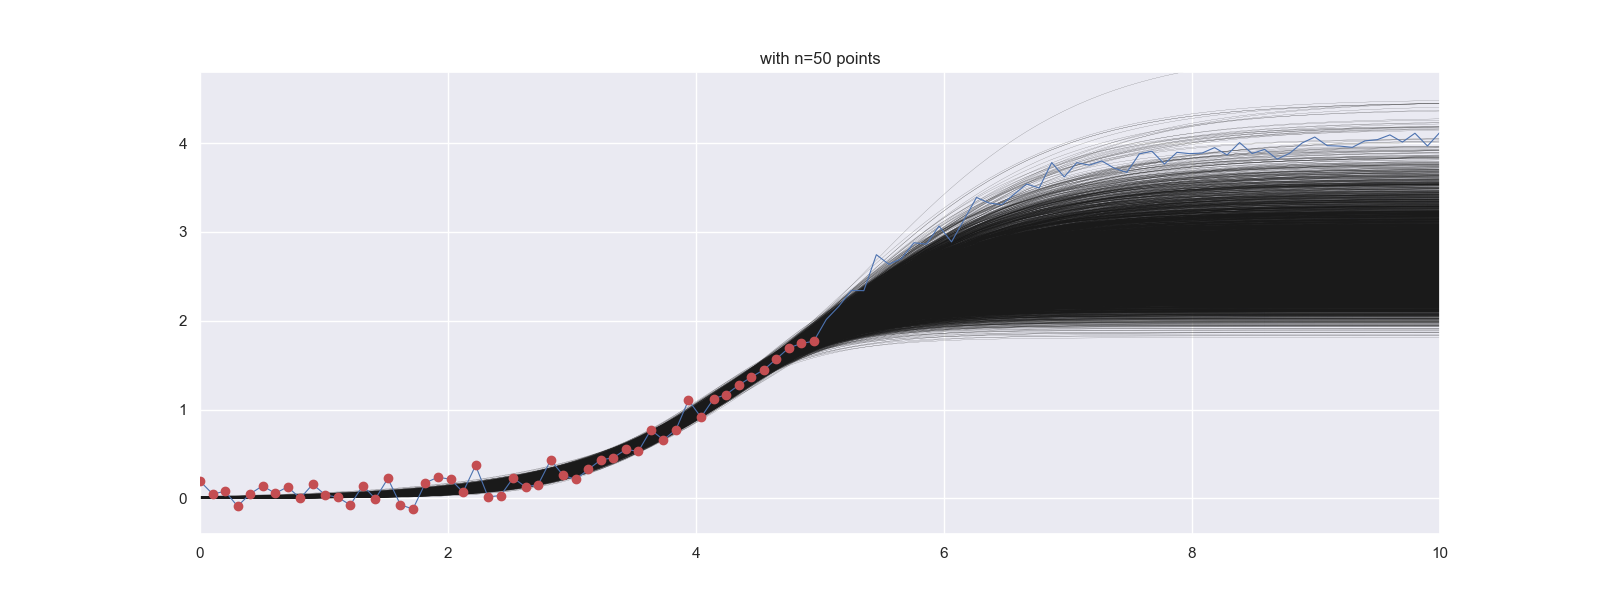

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.11      0.30      4.08      3.65      4.58   1380.32      1.00
   epsilon      0.10      0.01      0.10      0.09      0.12   2082.22      1.00
         k      1.17      0.07      1.17      1.07      1.29   1437.07      1.00
       t_0      5.06      0.14      5.05      4.82      5.27   1380.86      1.00

Number of divergences: 0


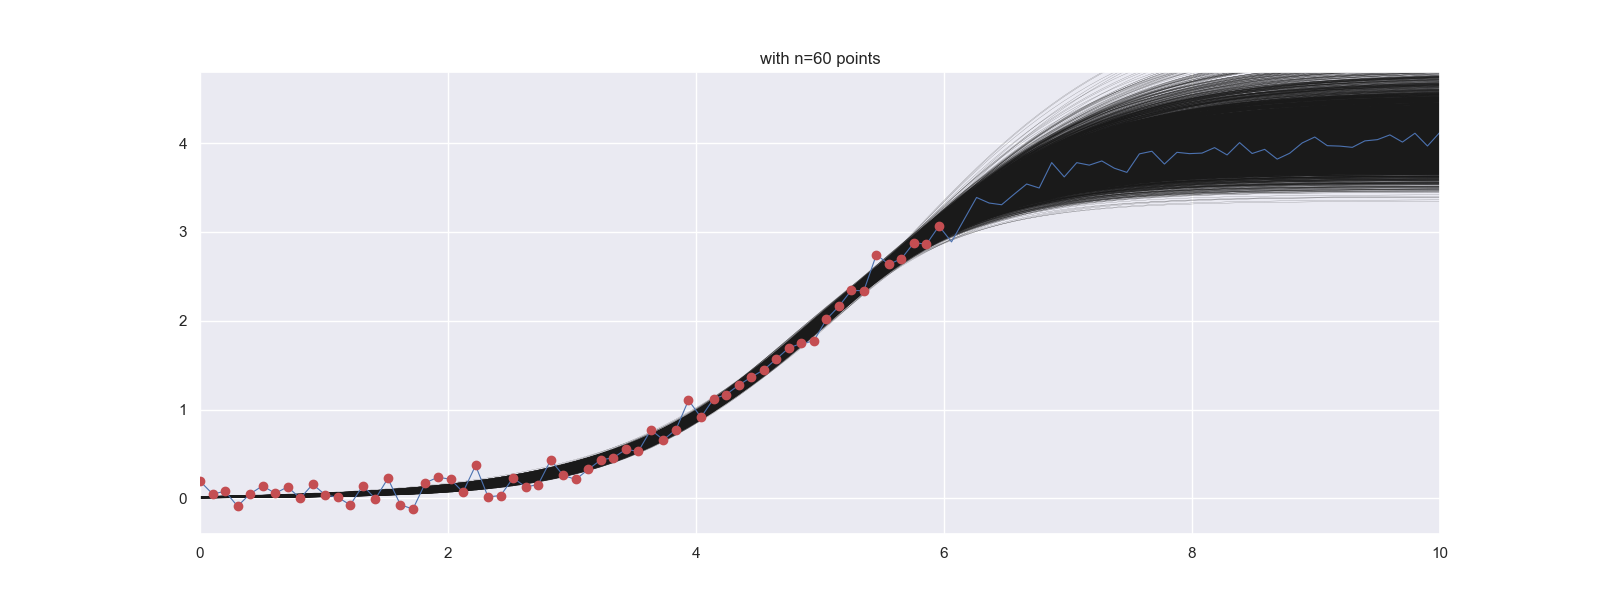

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.03      0.10      4.02      3.88      4.18   1548.57      1.00
   epsilon      0.10      0.01      0.10      0.09      0.12   2688.07      1.00
         k      1.17      0.04      1.17      1.11      1.25   1732.33      1.00
       t_0      5.03      0.06      5.02      4.93      5.12   1539.20      1.00

Number of divergences: 0


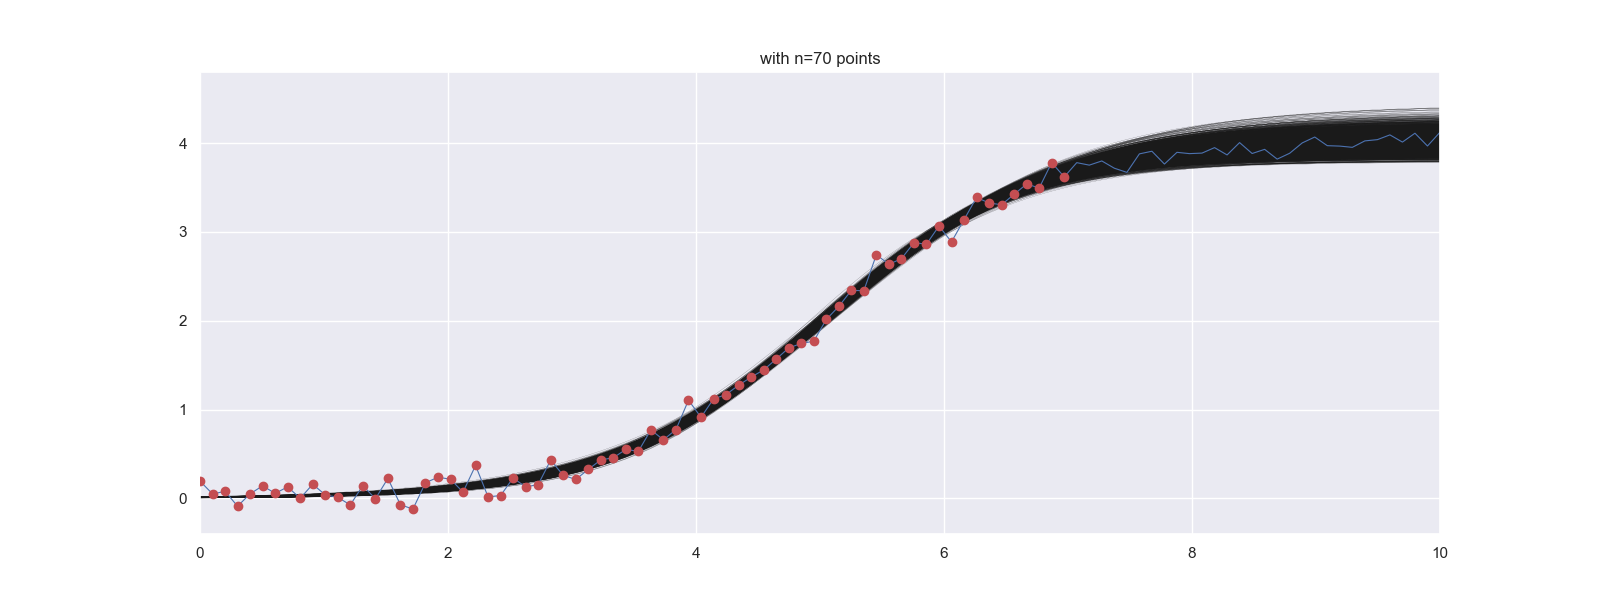

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.01      0.04      4.01      3.94      4.08   1464.71      1.00
   epsilon      0.10      0.01      0.10      0.09      0.11   3113.17      1.00
         k      1.18      0.03      1.18      1.13      1.24   1923.89      1.00
       t_0      5.02      0.03      5.02      4.97      5.07   1645.79      1.00

Number of divergences: 0


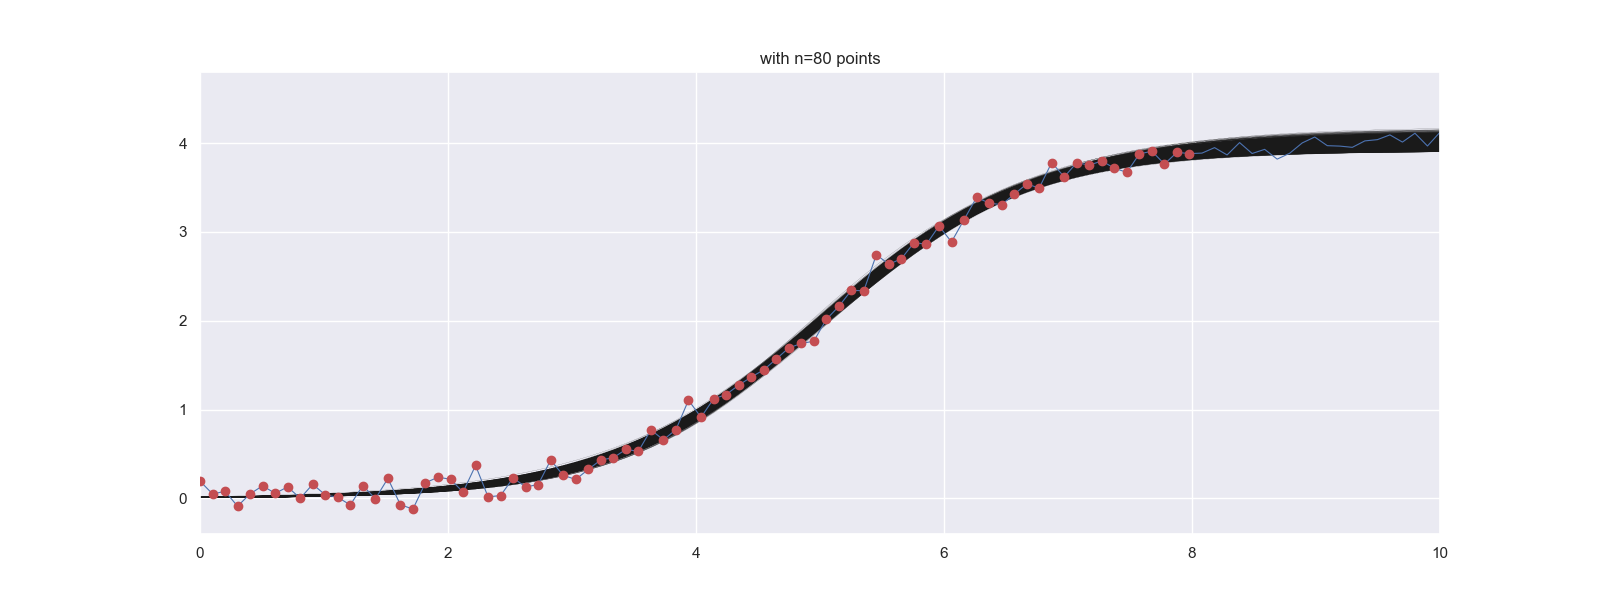

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.08      0.01      4.08      4.07      4.09   3849.44      1.00
   epsilon      0.10      0.01      0.10      0.09      0.11   5105.02      1.00
         k      1.14      0.02      1.14      1.10      1.17   4495.69      1.00
       t_0      5.06      0.02      5.06      5.03      5.09   4487.01      1.00

Number of divergences: 7


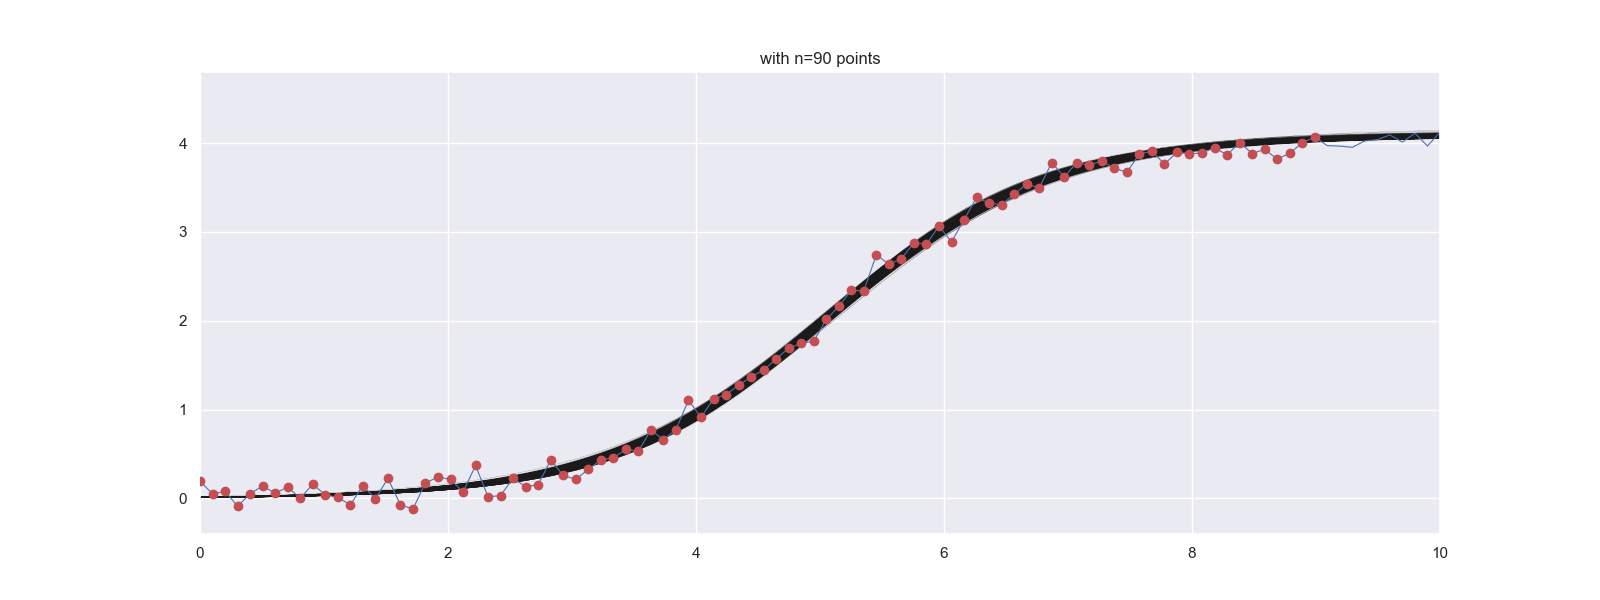

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.13      0.01      4.13      4.12      4.14   4975.97      1.00
   epsilon      0.11      0.01      0.10      0.09      0.12   5181.74      1.00
         k      1.10      0.02      1.10      1.07      1.14   4954.80      1.00
       t_0      5.09      0.02      5.09      5.06      5.13   4997.03      1.00

Number of divergences: 0


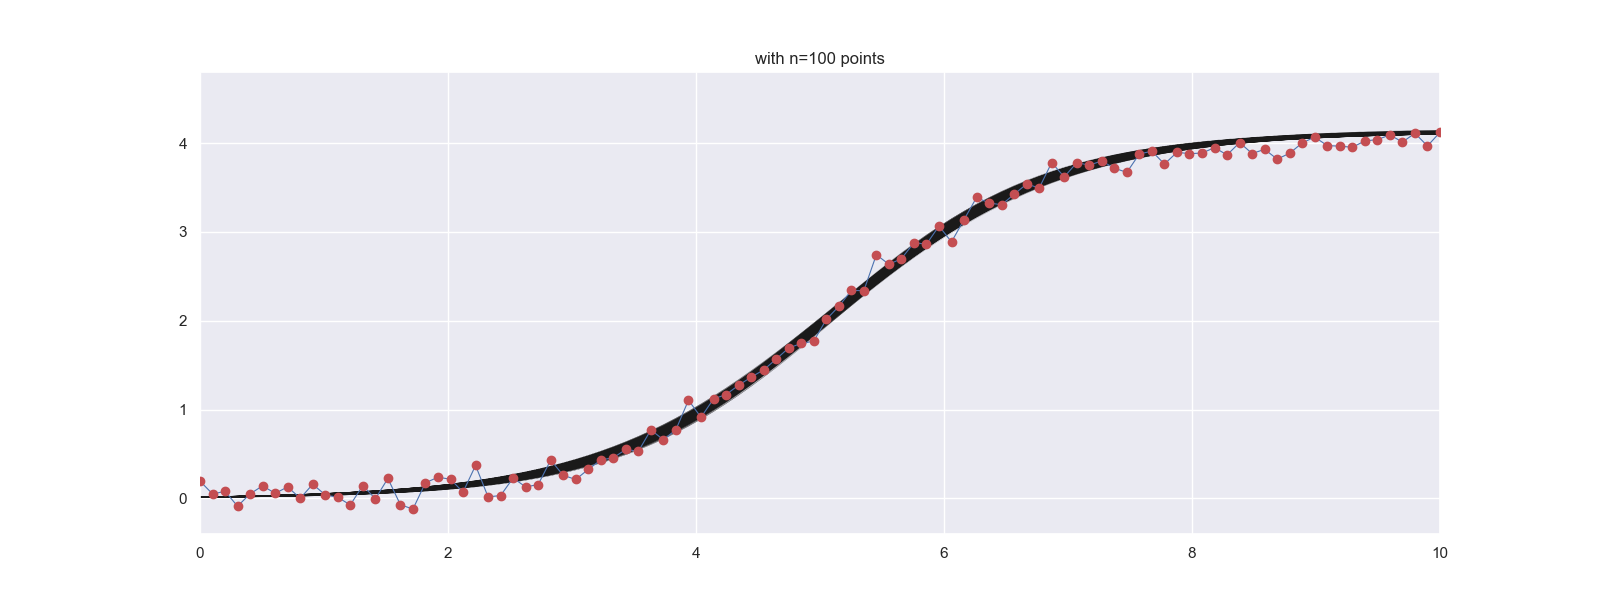

x         y
0  0.00000 -0.005565
1  0.10101  0.066202
2  0.20202  0.277439
3  0.30303 -0.434941
4  0.40404 -0.192925

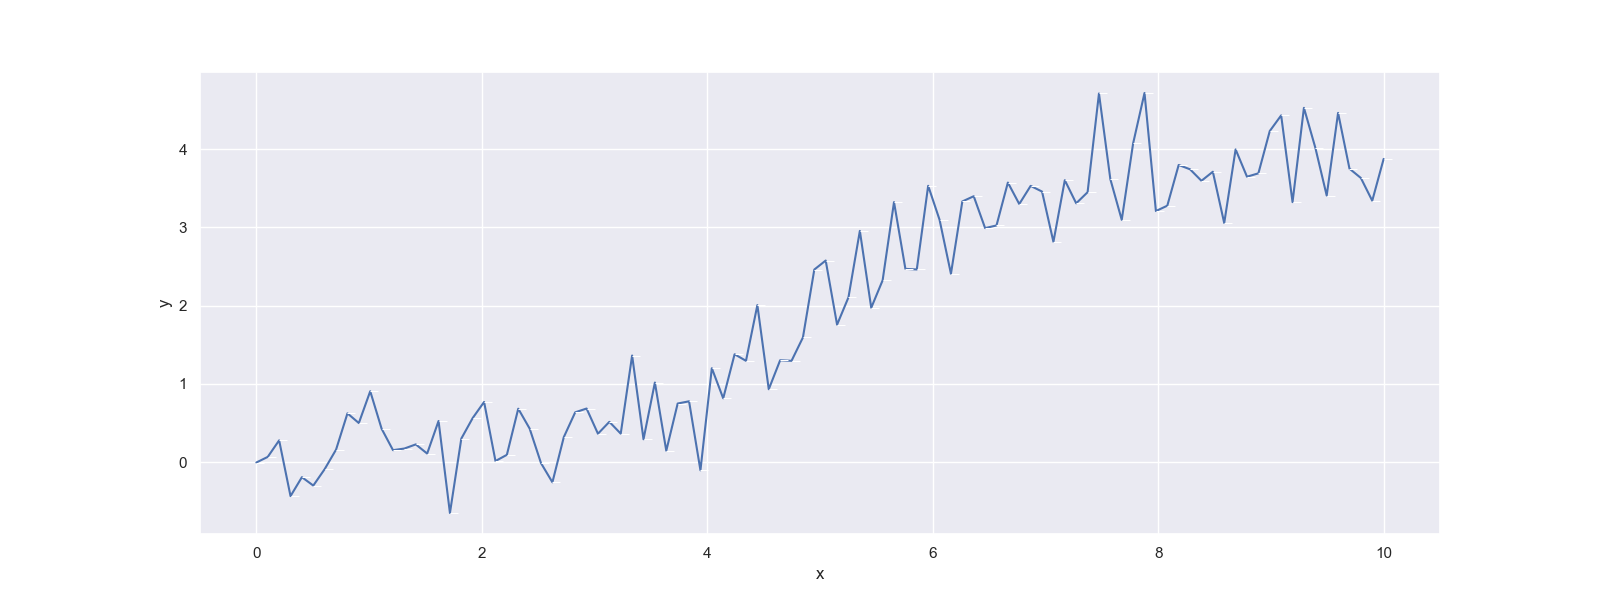

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.85      0.18      0.81      0.62      1.10   3478.41      1.00
   epsilon      0.33      0.10      0.31      0.19      0.46   2250.67      1.00
         k      4.38      1.99      4.16      1.42      7.64   2747.94      1.00
       t_0      1.09      0.28      1.04      0.69      1.56   2335.23      1.00

Number of divergences: 0


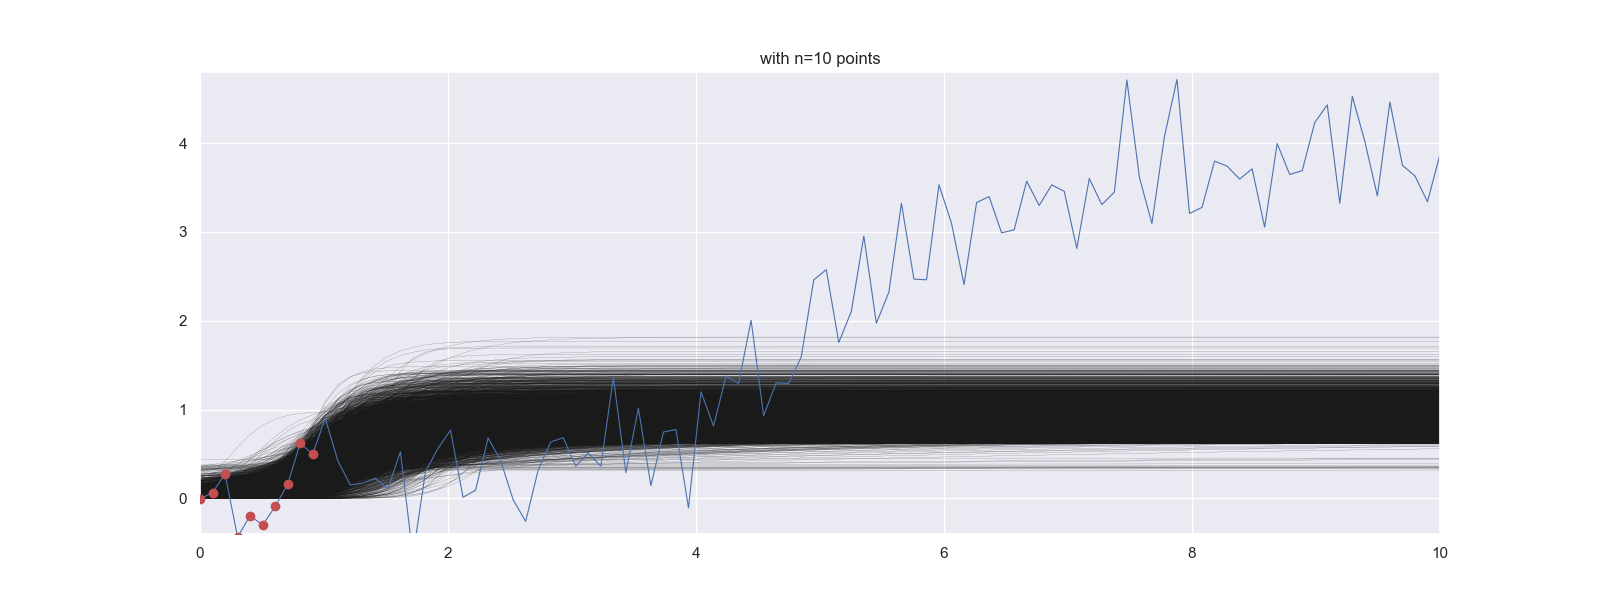

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      1.21      0.24      1.15      0.91      1.57   4091.23      1.00
   epsilon      0.41      0.07      0.40      0.30      0.52   3435.86      1.00
         k      2.30      1.63      1.80      0.37      4.72   3102.61      1.00
       t_0      2.57      0.59      2.48      1.69      3.51   2601.67      1.00

Number of divergences: 0


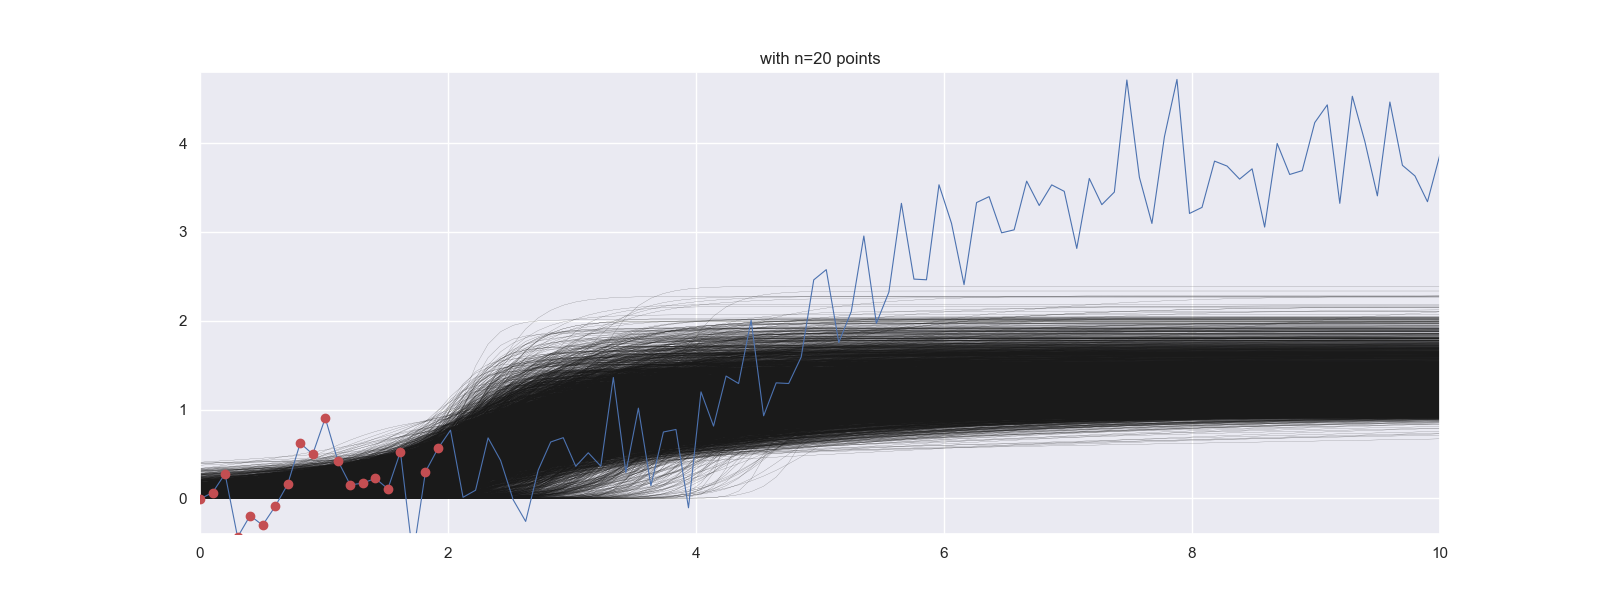

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      1.20      0.25      1.13      0.91      1.54   3700.12      1.00
   epsilon      0.38      0.06      0.38      0.29      0.46   2562.28      1.00
         k      1.20      1.01      0.91      0.21      2.24   1509.48      1.00
       t_0      3.57      0.78      3.42      2.42      4.79   2522.94      1.00

Number of divergences: 5


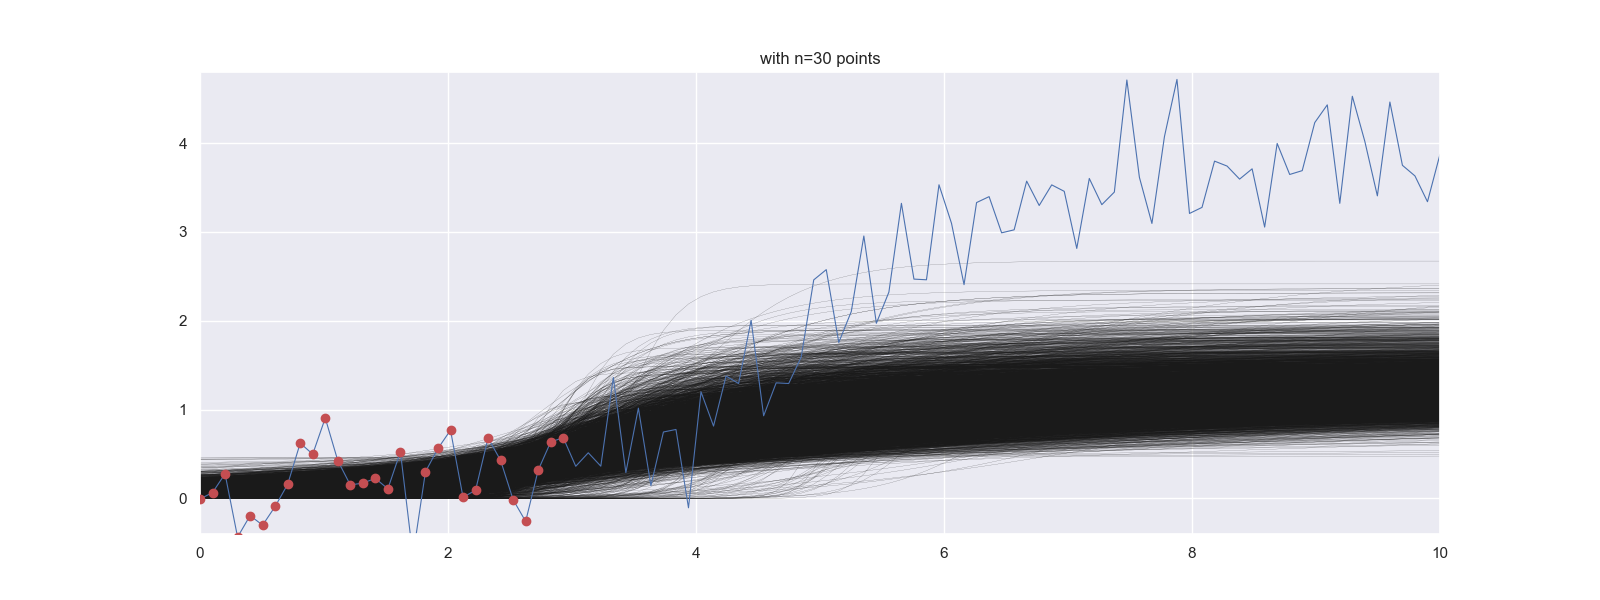

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      1.78      0.35      1.70      1.36      2.27   3416.90      1.00
   epsilon      0.40      0.05      0.39      0.32      0.46   3493.96      1.00
         k      0.65      0.27      0.61      0.28      1.02   2626.43      1.00
       t_0      5.01      0.96      4.84      3.56      6.48   2117.08      1.00

Number of divergences: 2


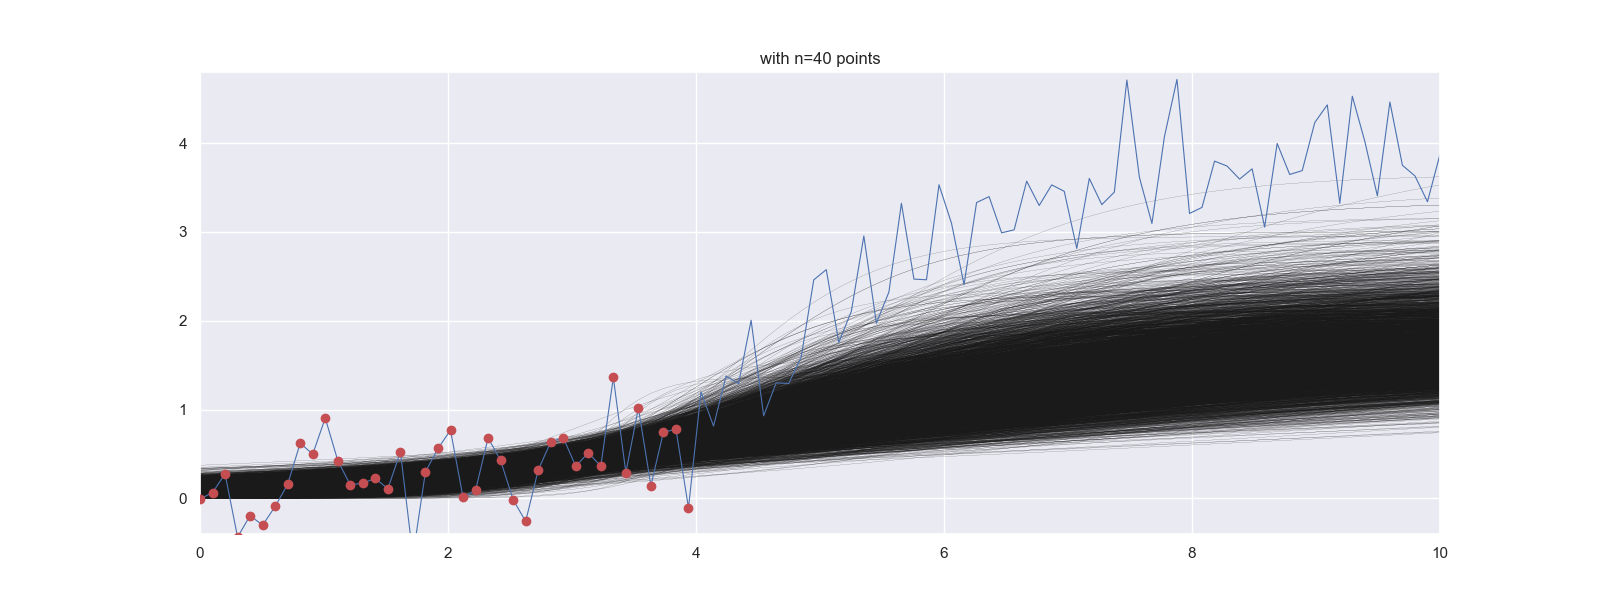

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      3.55      0.77      3.41      2.46      4.62   1709.04      1.00
   epsilon      0.41      0.04      0.41      0.35      0.48   2744.66      1.00
         k      1.00      0.23      0.97      0.64      1.33   2180.96      1.00
       t_0      5.02      0.45      4.96      4.27      5.68   1452.78      1.00

Number of divergences: 2


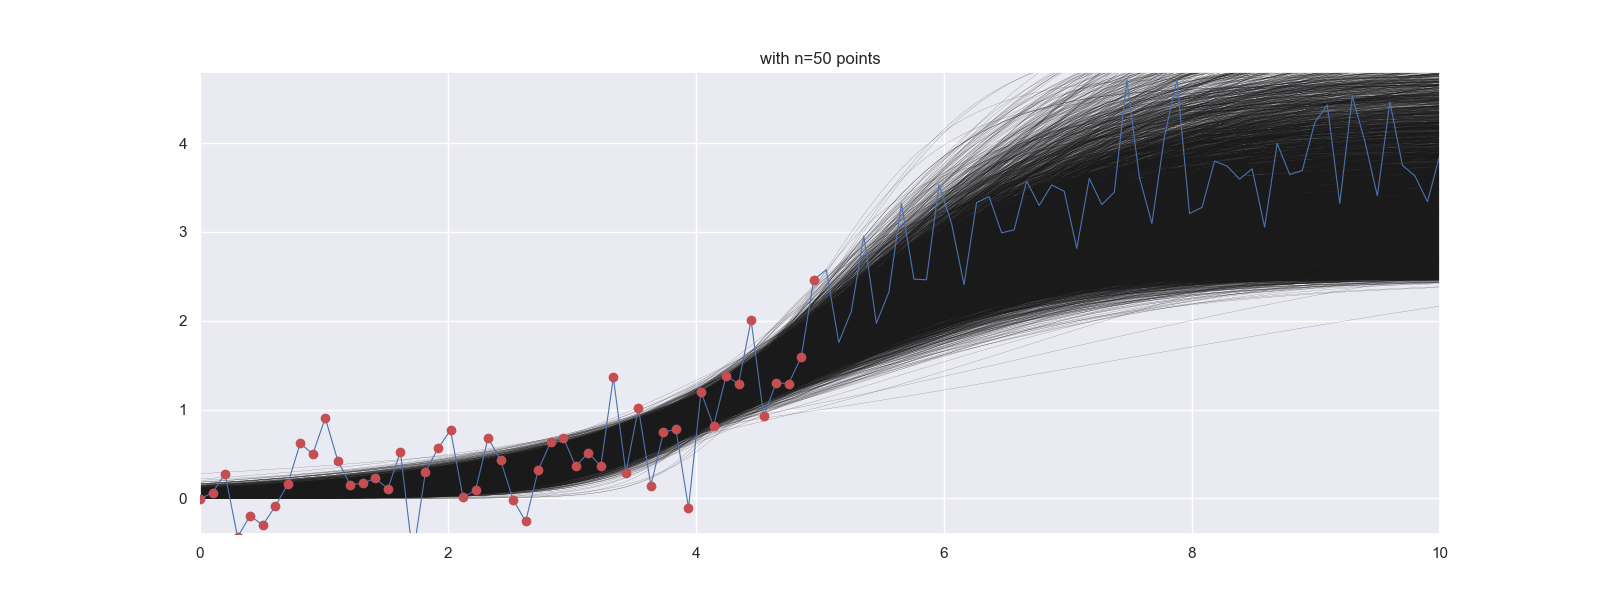

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      5.09      1.03      4.91      3.54      6.52   1145.19      1.00
   epsilon      0.42      0.04      0.42      0.36      0.49   2431.49      1.00
         k      0.98      0.15      0.96      0.75      1.21   1325.00      1.00
       t_0      5.51      0.42      5.47      4.83      6.16   1095.62      1.00

Number of divergences: 8


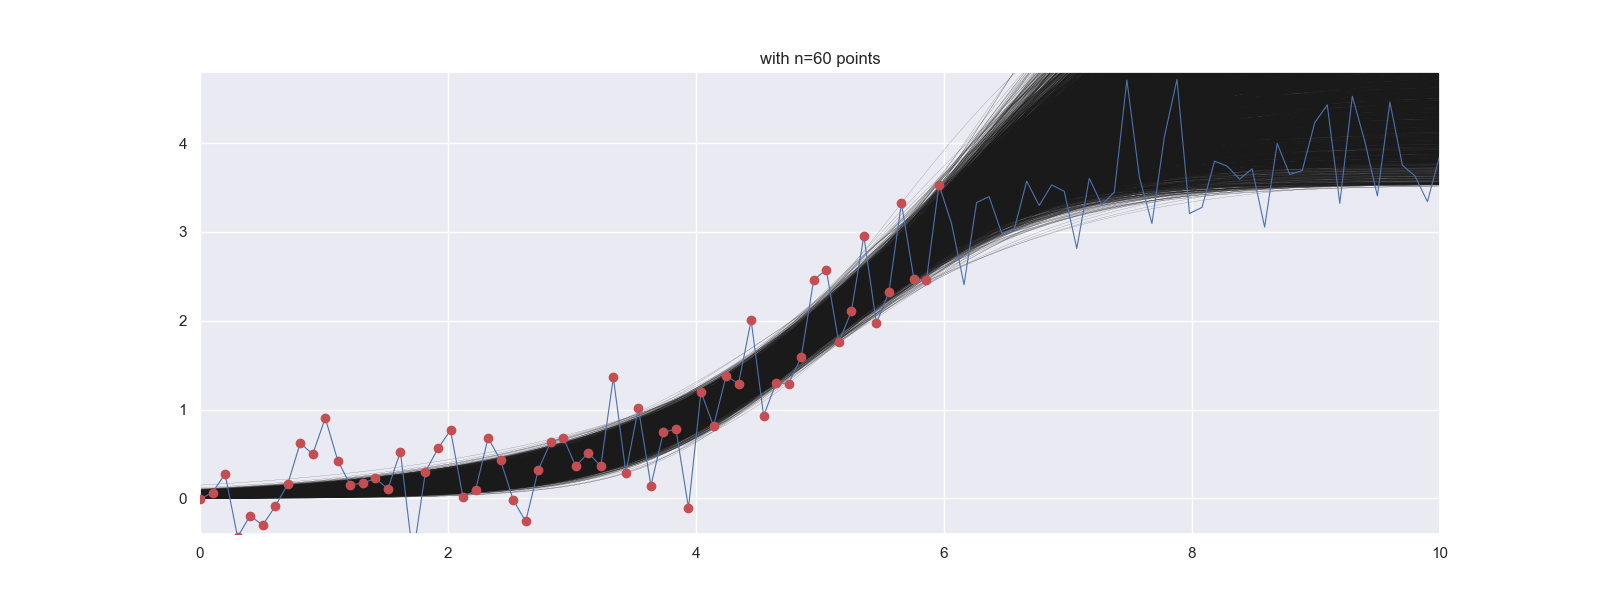

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.21      0.47      4.11      3.57      4.85    974.24      1.01
   epsilon      0.41      0.03      0.40      0.35      0.47   2067.01      1.00
         k      1.02      0.15      1.01      0.76      1.25   1345.08      1.00
       t_0      5.19      0.28      5.14      4.76      5.61    982.45      1.01

Number of divergences: 29


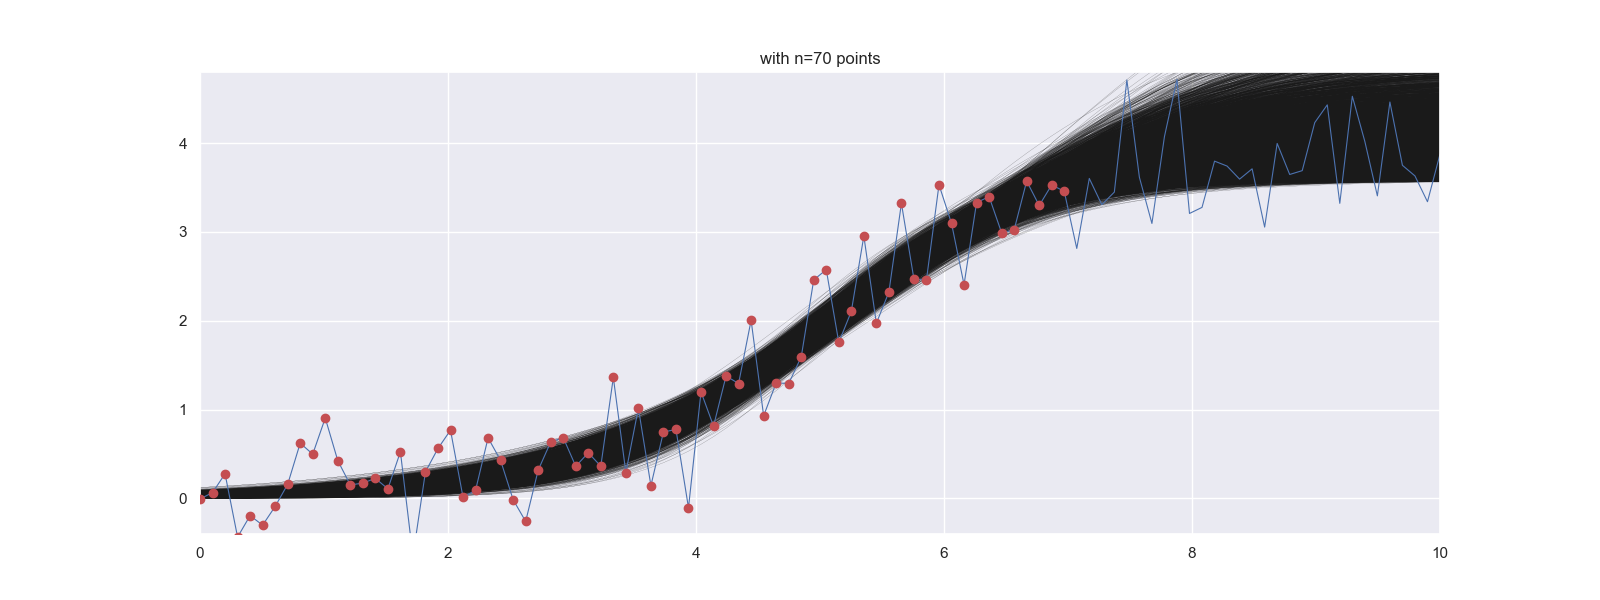

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.94      0.23      4.87      4.72      5.22    405.31      1.02
   epsilon      0.45      0.04      0.45      0.39      0.51   2626.24      1.00
         k      0.76      0.06      0.76      0.66      0.86   1237.09      1.00
       t_0      5.72      0.18      5.69      5.45      5.97    467.46      1.02

Number of divergences: 31


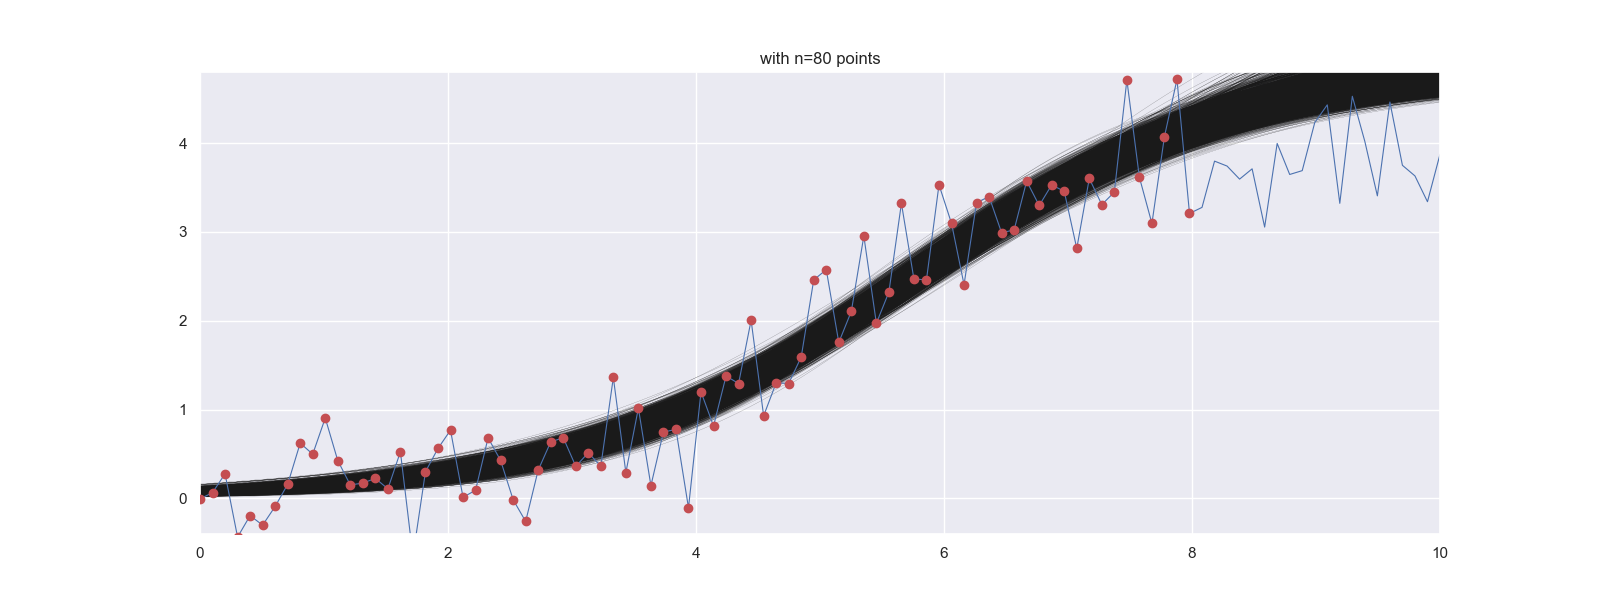

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.81      0.10      4.78      4.72      4.93    425.87      1.00
   epsilon      0.48      0.04      0.47      0.42      0.54   3795.47      1.00
         k      0.69      0.05      0.69      0.60      0.77   1348.80      1.00
       t_0      5.75      0.13      5.74      5.53      5.94    586.69      1.00

Number of divergences: 38


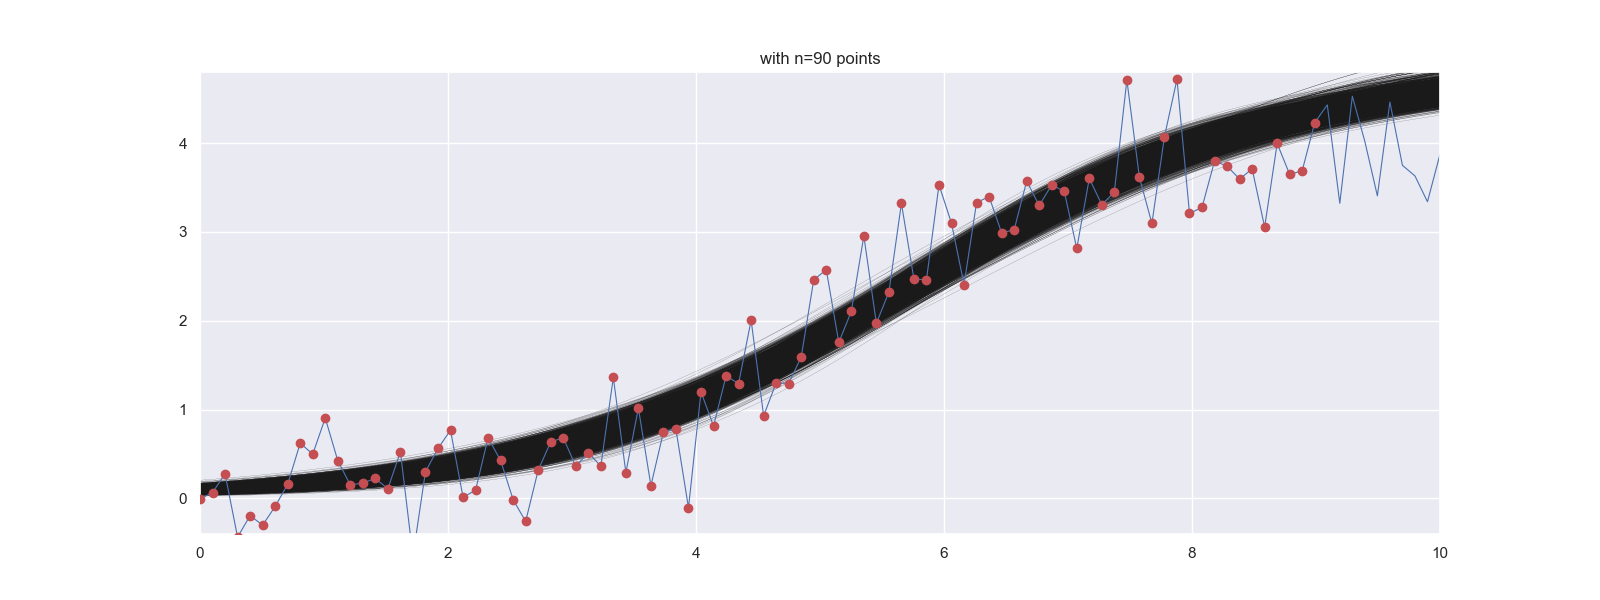

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      4.77      0.05      4.75      4.72      4.84   2914.28      1.00
   epsilon      0.50      0.04      0.50      0.44      0.56   4370.82      1.00
         k      0.64      0.05      0.64      0.57      0.72   4297.54      1.00
       t_0      5.78      0.12      5.78      5.59      5.98   3538.70      1.00

Number of divergences: 5


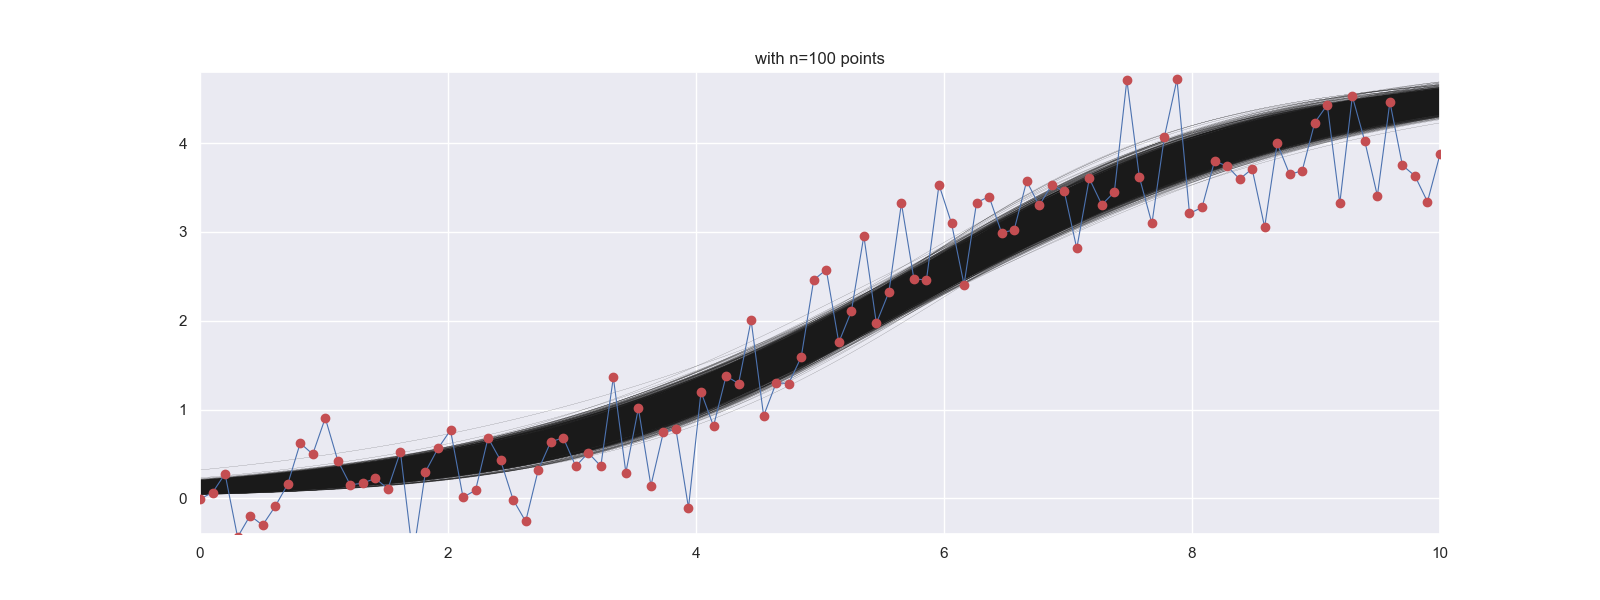

In [22]:
for noise_scale in [0.01, 0.1, 0.4]:

    os.makedirs(f'img/noise_{noise_scale}/', exist_ok=True)

    # make some data
    df = pd.DataFrame(
        np.transpose(logistic(L=L, k=k, x_0=x_0, noise_scale=noise_scale, x_min=x_min, x_max=x_max, n_points=n_points)),
        columns=['x', 'y'])
    display(df.head())

    plt.figure(figsize=(16, 6))
    sns.lineplot(data=df, x='x', y='y', marker=True)
    plt.show()
    plt.close()

    for i in np.arange(10, n_points+10, 10):
        jj = int(i)
        df_obs = df[:jj]

        t_obs =  df_obs['x'].values
        y_obs = df_obs['y'].to_numpy()

        mcmc, prior, posterior_samples = predict(t_obs, y_obs)

        x_pred, y_pred = build_predictive_posteriors(x_min=x_min, x_max=x_max, n_points=n_points, posterior_samples=posterior_samples)

        plt.figure(figsize=(16, 6))
        plt.plot(x_pred, y_pred, linewidth=0.1, color='k', zorder=1) # alpha=0.02,
        plt.plot(df['x'], df['y'], color='b', zorder=2, linewidth=0.8)
        plt.scatter(t_obs, y_obs, zorder=3, color='r')
        plt.title(f'with n={jj} points')
        plt.xlim(x_min, x_max)
        plt.ylim(-0.1*L, 1.2*L)
        plt.savefig(f'img/noise_{noise_scale}/pred_{jj:04}.png', transparent=True, dpi=200)
        plt.show()
        plt.close()

In [21]:
print('done')

done


How cool is that?